# Clustering Experiments for 'Explaining RL Decisions with Trajectories': A Reproducibility Study

This file contains code used for generating results of the gridworld experiments.

In [1]:
# Regular data science libraries
import numpy as np
import pandas as pd
import json
import os
import pickle
import random


# DNN libraries
import torch
import torch.nn as nn
import torch.nn.functional as F


# Import utility functions from other files
from utils import generate_model, dp, generate_offline_data
from env import Agent, Environment


# Plotting libraries
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import scienceplots
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
plt.style.use('ieee')


# Clustering libraries
from sklearn.decomposition import PCA
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.utils import read_sample
from pyclustering.samples.definitions import SIMPLE_SAMPLES
from scipy.stats import wasserstein_distance

# Set the seeds
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)


### Instantiate the Environment

Pick one of the three provided environments: FourRooms, 7x7 (default), or 5x5. The environment implementation is provided in a script attached with this notebook.

In [2]:
# # Four Rooms Environment

# action_dict = {0: 'LEFT', 1: 'UP', 2: 'RIGHT', 3: 'DOWN'}
# reward_dict = {1:0, -1:1, -0.1:2, 0:3}

# #####

# # Environment Definition
# env_width = 11
# env_height = 11
# env = Environment(dim=(env_width, env_height),
# #                   starts=[(2, 0), (6, 2), (2,4), (5,5)],
#                   terminals={(0, 0): +1, (0, 10): +1, (4, 3): -1, (8, 2):-1, (2, 8):+1, (3, 6):-1, (7,7):-1, (10, 6):-1, (10, 4):+1, (10, 8):+1},
#                   obstacles=[[0, 5], [1, 5], [3, 5], [4, 5], [5, 0], [5, 2], [5, 3], [5, 4], [5, 5], [6, 5], [7, 5], [8, 5], [10, 5], [6, 6], [6, 7], [6, 9], [6, 10]],
#                   stoc=0.)

# env.render(title='Four Rooms')

# # Initialize the agent
# agent = Agent(env)

# #####

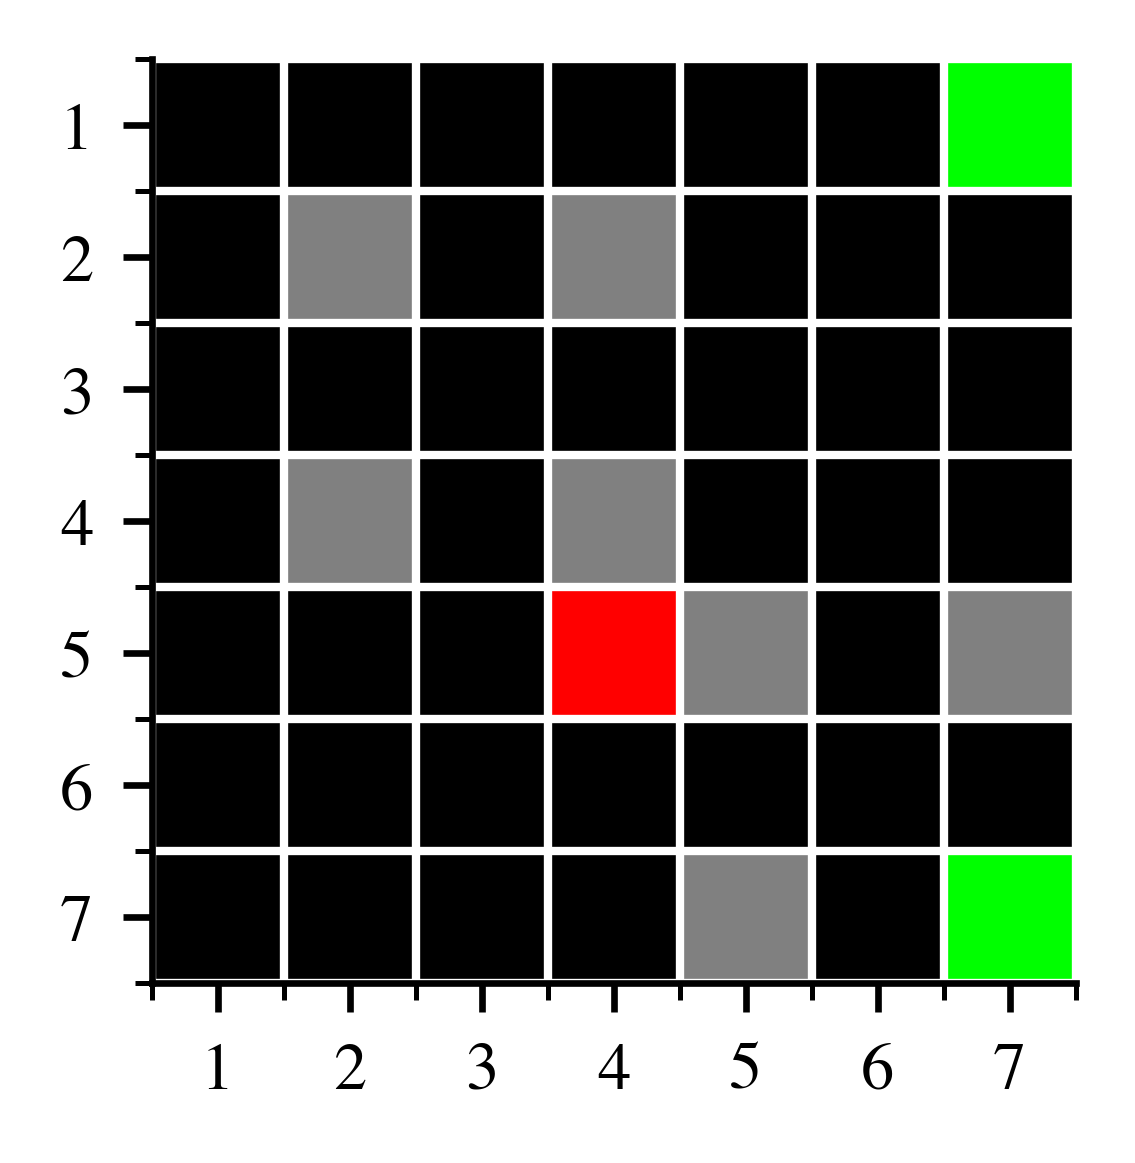

In [3]:
# # 7x7 Gridworld Environment
# # Set the seeds
# random.seed(0)
# np.random.seed(0)
# torch.manual_seed(0)

action_dict = {0: 'LEFT', 1: 'UP', 2: 'RIGHT', 3: 'DOWN'}
reward_dict = {1:0, -1:1, -0.1:2, 0:3}

#####

# Environment Definition
env_width = 7
env_height = 7
env = Environment(dim=(env_width, env_height),
                  starts=[(2, 0), (6, 2), (2,4)],
                  terminals={(0, 6): +1, (6, 6): +1, (4, 3): -1},
                  obstacles=[[1, 1], [1, 3], [3, 1], [3, 3], [4,4], [6, 4], [4,6]],
                  stoc=0.)

env.render(title='7x7 Gridworld')

# Initialize the agent
agent = Agent(env)

#####

In [4]:
# # 5x5 Gridworld Environment
# action_dict = {0: 'LEFT', 1: 'UP', 2: 'RIGHT', 3: 'DOWN'}
# reward_dict = {1:0, -1:1, -0.1:2, 0:3}

# #####

# # Environment Definition
# env_width = 5
# env_height = 5
# env = Environment(dim=(env_width, env_height),
#                   starts=[(4, 4), (4, 2)],
#                   terminals={(0, 1): +1, (4, 4): -1},
#                   obstacles=[[3,2],[3,3]],
#                   stoc=0.)

# env.render(title='Gridworld')

# # Initialize the agent
# agent = Agent(env)

# #####

### Collecting offline trajectory data

In [5]:
# # Generate offline data for the training
# # # Set the seeds
# # random.seed(0)
# # np.random.seed(0)
# # torch.manual_seed(0)

# num_episodes_dyna = 5
# num_agents_dyna = 10
# max_traj_len = 10
# num_pos_trajs = 250
# num_neg_trajs = 50
# offline_data = generate_offline_data(env, agent, num_episodes_dyna, num_agents_dyna, max_traj_len, num_pos_trajs, num_neg_trajs)

#####

In [6]:
# Generate offline data for the training
# # Set the seeds
# random.seed(0)
# np.random.seed(0)
# torch.manual_seed(0)

# num_episodes_dyna = 2
# num_agents_dyna = 5
# max_traj_len = 10
# num_pos_trajs = 50
# num_neg_trajs = 10
# offline_data = generate_offline_data(env, agent, num_episodes_dyna, num_agents_dyna, max_traj_len, num_pos_trajs, num_neg_trajs)

# #####

In [7]:
# # If you are planning to pickle these trajectories and use them instead of generating them every time...
# # # 300 trajectories
# num_episodes_dyna = 5
# num_agents_dyna = 10
# max_traj_len = 10
# num_pos_trajs = 250
# num_neg_trajs = 50
# results_save_dir = './gridworld_results/grid_7by7/'
# # with open(os.path.join(results_save_dir, 'offline_traj300.pkl'), 'wb') as f:
# #     pickle.dump(offline_data, f)

# with open(os.path.join(results_save_dir, 'offline_traj300.pkl'), 'rb') as f:
#     offline_data = pickle.load(f)

In [8]:
# # # ## 60 trajectories
num_episodes_dyna = 2
num_agents_dyna = 5
max_traj_len = 10
num_pos_trajs = 50
num_neg_trajs = 10
results_save_dir = './gridworld_results/grid_7by7/'
# with open(os.path.join(results_save_dir, 'offline_traj60.pkl'), 'wb') as f:
#     pickle.dump(offline_data, f)

with open(os.path.join(results_save_dir, 'offline_traj60.pkl'), 'rb') as f:
    offline_data = pickle.load(f)

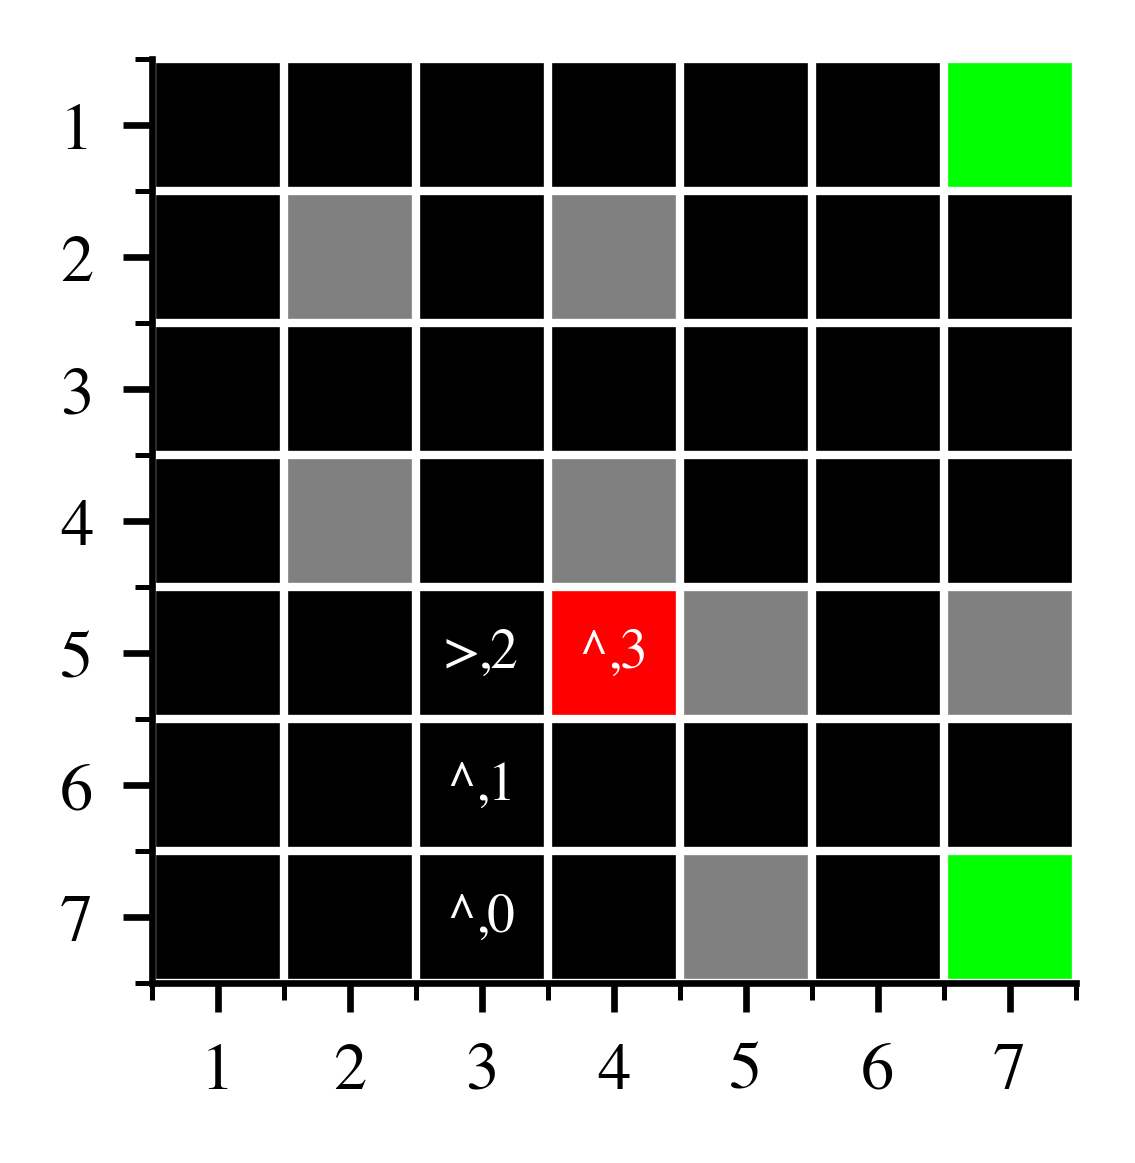

In [9]:
# Plot a trajectory to check if the data has been correctly formed
env.plot_traj(offline_data[-1])

## Sequential Encoder (i)

We use sequential encoder to parse the offline data and create clusters of the trajectories which will be used for attributing the decisions in the later steps.

In [10]:
# Set the seeds
# random.seed(0)
# np.random.seed(0)
# torch.manual_seed(0)

def tokenizer(trajectories, state_space_dim, action_dict, reward_dict, max_traj_len = 25):
    """
        Tokenizer for capturing gridworld trajectories
    """

    action_space_dim = len(action_dict)
    reward_set_dim = len(reward_dict)
    
    # TOKEN IDs
    # 1 START TOKEN
    # 2 END TOKEN
    # 0 PAD TOKEN
    # STATE TOKENs
    # ACTION TOKENs
    # REWARD TOKENs
    
    complete_traj_tokens = []
    
    for traj in trajectories:
        # Traj contains (s,a,r,s')
        # We generate tokens for 's', 'a' and 'r'
        
        traj_tokens = []
        
        # Start token
        traj_tokens.append(1)
        
        for sars_ in traj:
            s = sars_[0]
            a = sars_[1]
            r = sars_[2]
            
            # State
            traj_tokens.append(3 + s)
            
            # Action
            traj_tokens.append(3 + state_space_dim + a)
            
            # Reward
            traj_tokens.append(3 + state_space_dim + action_space_dim + reward_dict[r])
        
        # Remove action and reward for terminal state, TO BE USED ONLY when (s_terminal, a_random, reward = 0, s_terminal) exists at the end of trajectory data
        traj_tokens.pop()
        traj_tokens.pop()
        
        # End token
        traj_tokens.append(2)
        
        # Pad with zero tokens
        if max_traj_len + 3 - len(traj) > 0:
            traj_tokens = traj_tokens + [0]*(3*(max_traj_len + 3 - len(traj)))
        
        complete_traj_tokens.append(torch.LongTensor(traj_tokens))
    
    return complete_traj_tokens

vocab_size = 3 + env_width*env_height + len(action_dict) + len(reward_dict)

tokenized_data = tokenizer(offline_data, 
                          state_space_dim = env_width*env_height, 
                          action_dict = action_dict, 
                          reward_dict = reward_dict, 
                          max_traj_len = max_traj_len)

In [11]:
class LSTMEncoder(nn.Module):
    def __init__(self, embedding_dim, vocab_size, hidden_size):
        super(LSTMEncoder, self).__init__()
        self.hidden_size = hidden_size
        self.token_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size)

    def forward(self, traj):
        embeds = self.token_embeddings(traj)
        o, (h_n, c_n) = self.lstm(embeds.view(len(traj), 1, -1)) # Batch first is false, -> Input shape (L(seq len), N(num seq), H_in(hidden size))
        # The LSTM output contains :
        # o - Outputs of individual cells : shape (L, N, H)
        # h_n - Final hidden state
        # c_n - Final cell state
        return o[-1], (h_n, c_n)
    
class LSTMDecoder(nn.Module):
    def __init__(self, embedding_size, hidden_size, vocab_size):
        super(LSTMDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                      embedding_dim=embedding_size,
                                      )

        self.lstm = nn.LSTM(embedding_size, hidden_size)
        self.out = nn.Linear(hidden_size, vocab_size)

    def forward(self, input, hidden_state, cell_state):
        # Input is START TOKEN
        # Hidden state, Cell state are taken from encoder's output

        # Get embedding
        embedded = self.embedding(input)        
        output = embedded.view(len(input), 1, -1)
        
        # Run LSTM to decode the trajectory
        output, _ = self.lstm(output, (hidden_state, cell_state))
        
        # Convert LSTM logits to vocab size softmax 
        out = self.out(output.squeeze(1))
        output = F.log_softmax(out, dim=1)
        
        return output

class Seq2Seq(nn.Module):
    
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, traj):
        traj_embedding = self.encoder(traj[1:])
        decoded_traj = self.decoder(traj[:-1], traj_embedding[1][0], traj_embedding[1][1])
        return decoded_traj, traj_embedding

traj_encoder = LSTMEncoder(embedding_dim=16, vocab_size= vocab_size, hidden_size=32)
traj_decoder = LSTMDecoder(embedding_size=16, hidden_size=32, vocab_size=vocab_size)

model = Seq2Seq(traj_encoder, traj_decoder)


### Training LSTM to encode trajectories in a seq2seq setting

In [12]:
# # Set the seeds
# random.seed(0)
# np.random.seed(0)
# torch.manual_seed(0)

# Hyperparameters 
num_epochs = 25

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=1)

In [13]:
# # Set the seeds
# random.seed(0)
# np.random.seed(0)
# torch.manual_seed(0)
from codecarbon import OfflineEmissionsTracker
tracker = OfflineEmissionsTracker(country_iso_code="NLD")
tracker.start()

model.train()

for epoch_id, epoch in enumerate(range(num_epochs)):
    total_loss = 0
    for traj_id, traj in enumerate(tokenized_data):
        optimizer.zero_grad()
        
        # Get decoded trajectory and its embedding
        decoded_traj, traj_embedding = model(traj)
        # Loss
        loss = F.nll_loss(decoded_traj.view(-1, vocab_size),
                        traj[1:].contiguous().view(-1),
                        ignore_index=0)
        
        # Optimize the model
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
        optimizer.step()
        
        # Record loss
        total_loss += loss.data.item()

    total_loss = total_loss / 100
    
    print(f'Epoch: {epoch_id + 1}, Loss:{total_loss}')


[codecarbon INFO @ 15:24:58] offline tracker init
[codecarbon INFO @ 15:24:58] [setup] RAM Tracking...
[codecarbon INFO @ 15:24:58] [setup] GPU Tracking...
[codecarbon INFO @ 15:24:58] No GPU found.
[codecarbon INFO @ 15:24:58] [setup] CPU Tracking...
[codecarbon WARNING @ 15:24:58] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 15:24:58] We saw that you have a Apple M2 Pro but we don't know it. Please contact us.
[codecarbon INFO @ 15:24:58] CPU Model on constant consumption mode: Apple M2 Pro
[codecarbon INFO @ 15:24:58] >>> Tracker's metadata:
[codecarbon INFO @ 15:24:58]   Platform system: macOS-14.2.1-arm64-arm-64bit
[codecarbon INFO @ 15:24:58]   Python version: 3.8.18
[codecarbon INFO @ 15:24:58]   CodeCarbon version: 2.3.3
[codecarbon INFO @ 15:24:58]   Available RAM : 32.000 GB
[codecarbon INFO @ 15:24:58]   CPU count: 10
[codecarbon INFO @ 15:24:58]   CPU model: Apple M2 Pro
[codecarbon INFO @ 15:24:58]   GPU count: None
[codecarbon INFO 

Epoch: 1, Loss:1.11340346544981
Epoch: 2, Loss:0.5122088016569615
Epoch: 3, Loss:0.3917909574881196
Epoch: 4, Loss:0.3165824056789279
Epoch: 5, Loss:0.2592676686123013
Epoch: 6, Loss:0.2183819454908371
Epoch: 7, Loss:0.19150890585035085
Epoch: 8, Loss:0.17201273366808892
Epoch: 9, Loss:0.1587253575026989
Epoch: 10, Loss:0.14653272299095987
Epoch: 11, Loss:0.13742611272260546
Epoch: 12, Loss:0.13037823842838406
Epoch: 13, Loss:0.1249823035672307
Epoch: 14, Loss:0.11977013442665338
Epoch: 15, Loss:0.11483585722744465
Epoch: 16, Loss:0.1119763720780611
Epoch: 17, Loss:0.1080980883911252
Epoch: 18, Loss:0.10567527451552451
Epoch: 19, Loss:0.10390043838880957
Epoch: 20, Loss:0.1015754290111363
Epoch: 21, Loss:0.10098108118399977
Epoch: 22, Loss:0.09863811549730599
Epoch: 23, Loss:0.09720131874084473
Epoch: 24, Loss:0.0958835768327117
Epoch: 25, Loss:0.09479318615980446


In [14]:
# torch.save(model.state_dict(), './ckpt_save_dir/seq2seq_traj_5.pth')
# torch.save(model.state_dict(), './ckpt_save_dir/seq2seq_traj_fourrooms.pth')
torch.save(model.state_dict(), './ckpt_save_dir/seq2seq_traj_7.pth')

## Trajectory PCA + Clustering (ii) 

In [15]:
# # Set the seeds
# random.seed(0)
# np.random.seed(0)
# torch.manual_seed(0)

# Load the trained model
traj_encoder = LSTMEncoder(embedding_dim=16, vocab_size= vocab_size, hidden_size=32)
traj_decoder = LSTMDecoder(embedding_size=16, hidden_size=32, vocab_size=vocab_size)

model = Seq2Seq(traj_encoder, traj_decoder)
# model.load_state_dict(torch.load('./ckpt_save_dir/seq2seq_traj_5.pth'))
# model.load_state_dict(torch.load('./ckpt_save_dir/seq2seq_traj_fourrooms.pth'))
model.load_state_dict(torch.load('./ckpt_save_dir/seq2seq_traj_7.pth'))

<All keys matched successfully>

### Encode trajectories in the offline dataset

In [16]:
# Load and generate trajectory embeddings
traj_embeddings = []

for traj_id, traj in enumerate(tokenized_data):
    with torch.no_grad():
        decoded_traj, traj_embedding = model(traj)
        # print(traj_embedding[1])
        traj_embeddings.append(torch.cat(traj_embedding[1], axis=-1).numpy().reshape(-1))

## traj_embeddings is a 60x64 dimensional vector. 
traj_embeddings[59].shape

(64,)

### PCA analysis of the trajectory embeddings

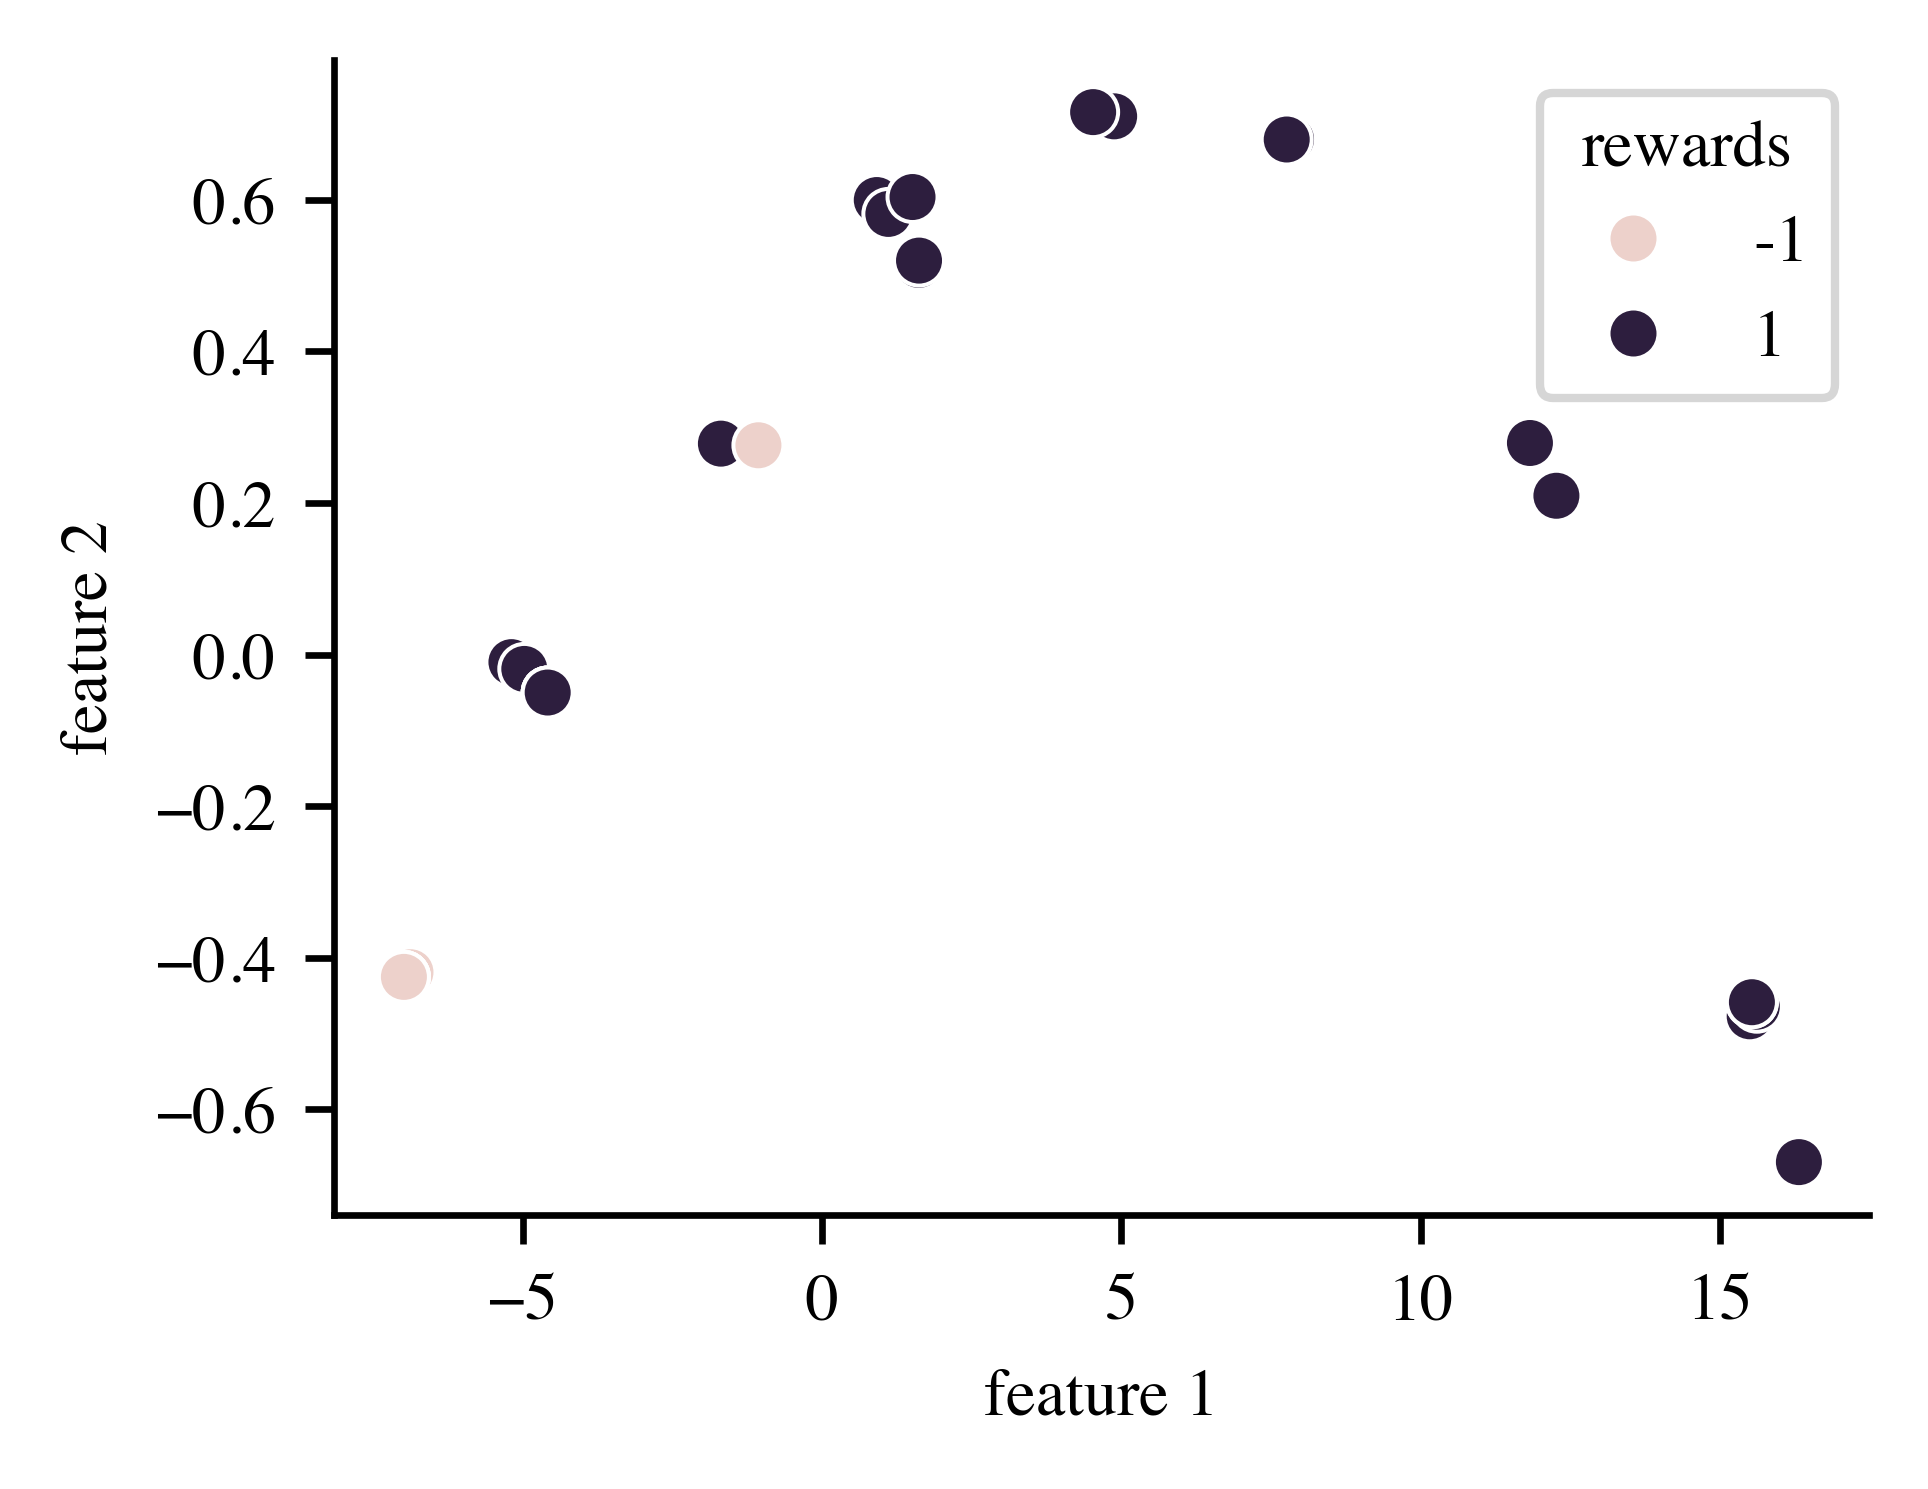

In [17]:
# Set the seeds
# random.seed(0)
# np.random.seed(0)
# torch.manual_seed(0)

pca = PCA(n_components=2)
pca_traj_embeddings = pca.fit_transform(traj_embeddings)
plotting_data = {'feature 1': pca_traj_embeddings[:, 0], 'feature 2': pca_traj_embeddings[:, 1],
                 'rewards': [+1] * num_pos_trajs + [-1] * num_neg_trajs}
df = pd.DataFrame(plotting_data)

plt.figure()
sns.scatterplot(x='feature 1', y='feature 2', hue='rewards', data=df)
# plt.title('PCA: Trajectory Embeddings')
# plt.legend()
plt.show()

# plt.figure()
# data_ax = sns.scatterplot(x='x',
#                           y='y',
#                           hue='labels',
#                           palette='deep',
#                           data=df,
#                           legend=True)
# for cid, _ in enumerate(cluster_data_embeds):
#     data_ax.text(pca_data_embeds[:, 0][cid],
#                  pca_data_embeds[:, 1][cid],
#                  str(cid),
#                  horizontalalignment='left',
#                  size='medium',
#                  color='black',
#                  weight='semibold')
# plt.title('PCA: Cluster Embeddings using ' + embed_gen_config['method_name'])
# plt.show()

### Clustering of the trajectories using X-Means

**(ii) Trajectory Clustering**

The following cell is just extracting clustering using `xmeans` from `pyclustering.cluster.xmeans`

If the following cell breaks just run it again, and it will work.

In [19]:
## IF THIS CELL BREAKS, RERUN THE CELL ONE MORE TIME AND EVERYTHING SHOULD WORK.

# Prepare initial centers - amount of initial centers defines amount of clusters from which X-Means will
# start analysis.
amount_initial_centers = 2
initial_centers = kmeans_plusplus_initializer(traj_embeddings, amount_initial_centers, random_state = 0).initialize()
 
# Create instance of X-Means algorithm. The algorithm will start analysis from 2 clusters, the maximum
# number of clusters that can be allocated is 10.
## mre then 10 clusters is pointless because by plotting them we see visually there are no more then 9.
xmeans_instance = xmeans(traj_embeddings, initial_centers, 10, random_state=0)
xmeans_instance.process()
 
# Extract clustering results: clusters and their centers
clusters = xmeans_instance.get_clusters()
centers = xmeans_instance.get_centers()
 
# Print total sum of metric errors
print("Total WCE:", xmeans_instance.get_total_wce())
print("Clusters:", clusters)
print('Number of clusters', len(clusters))

Total WCE: 2.6428404538520986
Clusters: [[0, 5, 12, 21], [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25], [51, 52, 53, 54, 56, 57, 58, 59], [55], [27, 28, 29, 30, 31, 32, 33, 34, 35], [26, 50], [42, 43, 44, 45, 46, 47, 48, 49], [40, 41], [38, 39], [36, 37]]
Number of clusters 10


In [20]:
# for cluster_id, cluster in enumerate(clusters):
#     print('-'*10)
#     print('Cluster ID', cluster_id)
#     for traj_id in cluster:
#         env.plot_traj(offline_data[traj_id])    
#     print('-'*10)

Initializing cluster labels and assigning to every cluster a color

In [21]:
traj_cluster_labels = np.zeros(len(traj_embeddings), dtype=int)

for cluster_id, cluster in enumerate(clusters):
    for traj_id in cluster:
        traj_cluster_labels[traj_id] = cluster_id

traj_cluster_labels

array([0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 9, 8, 8, 7, 7, 6, 6,
       6, 6, 6, 6, 6, 6, 5, 2, 2, 2, 2, 3, 2, 2, 2, 2])

In [22]:
palette = sns.color_palette('husl', len(clusters) + 1)
palette

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.8836443049112893, 0.5240073524369634, 0.19569304285113343),
 (0.710130687316902, 0.6046852192663268, 0.19426060163712158),
 (0.5432776721247529, 0.6540981095185215, 0.19324494273892204),
 (0.19592059105779686, 0.6981620017487838, 0.3452219818913641),
 (0.2067117296964458, 0.6829103404254792, 0.5829988925822328),
 (0.21420912437215422, 0.6714963557258681, 0.6986206664203177),
 (0.22537170008202412, 0.6531400148480775, 0.841007805313343),
 (0.5596943802099308, 0.5764402169887779, 0.9583930713150347),
 (0.8578978803740231, 0.44058452715322166, 0.957819659566579),
 (0.9628653850704806, 0.4025928454059796, 0.7779310354076443)]

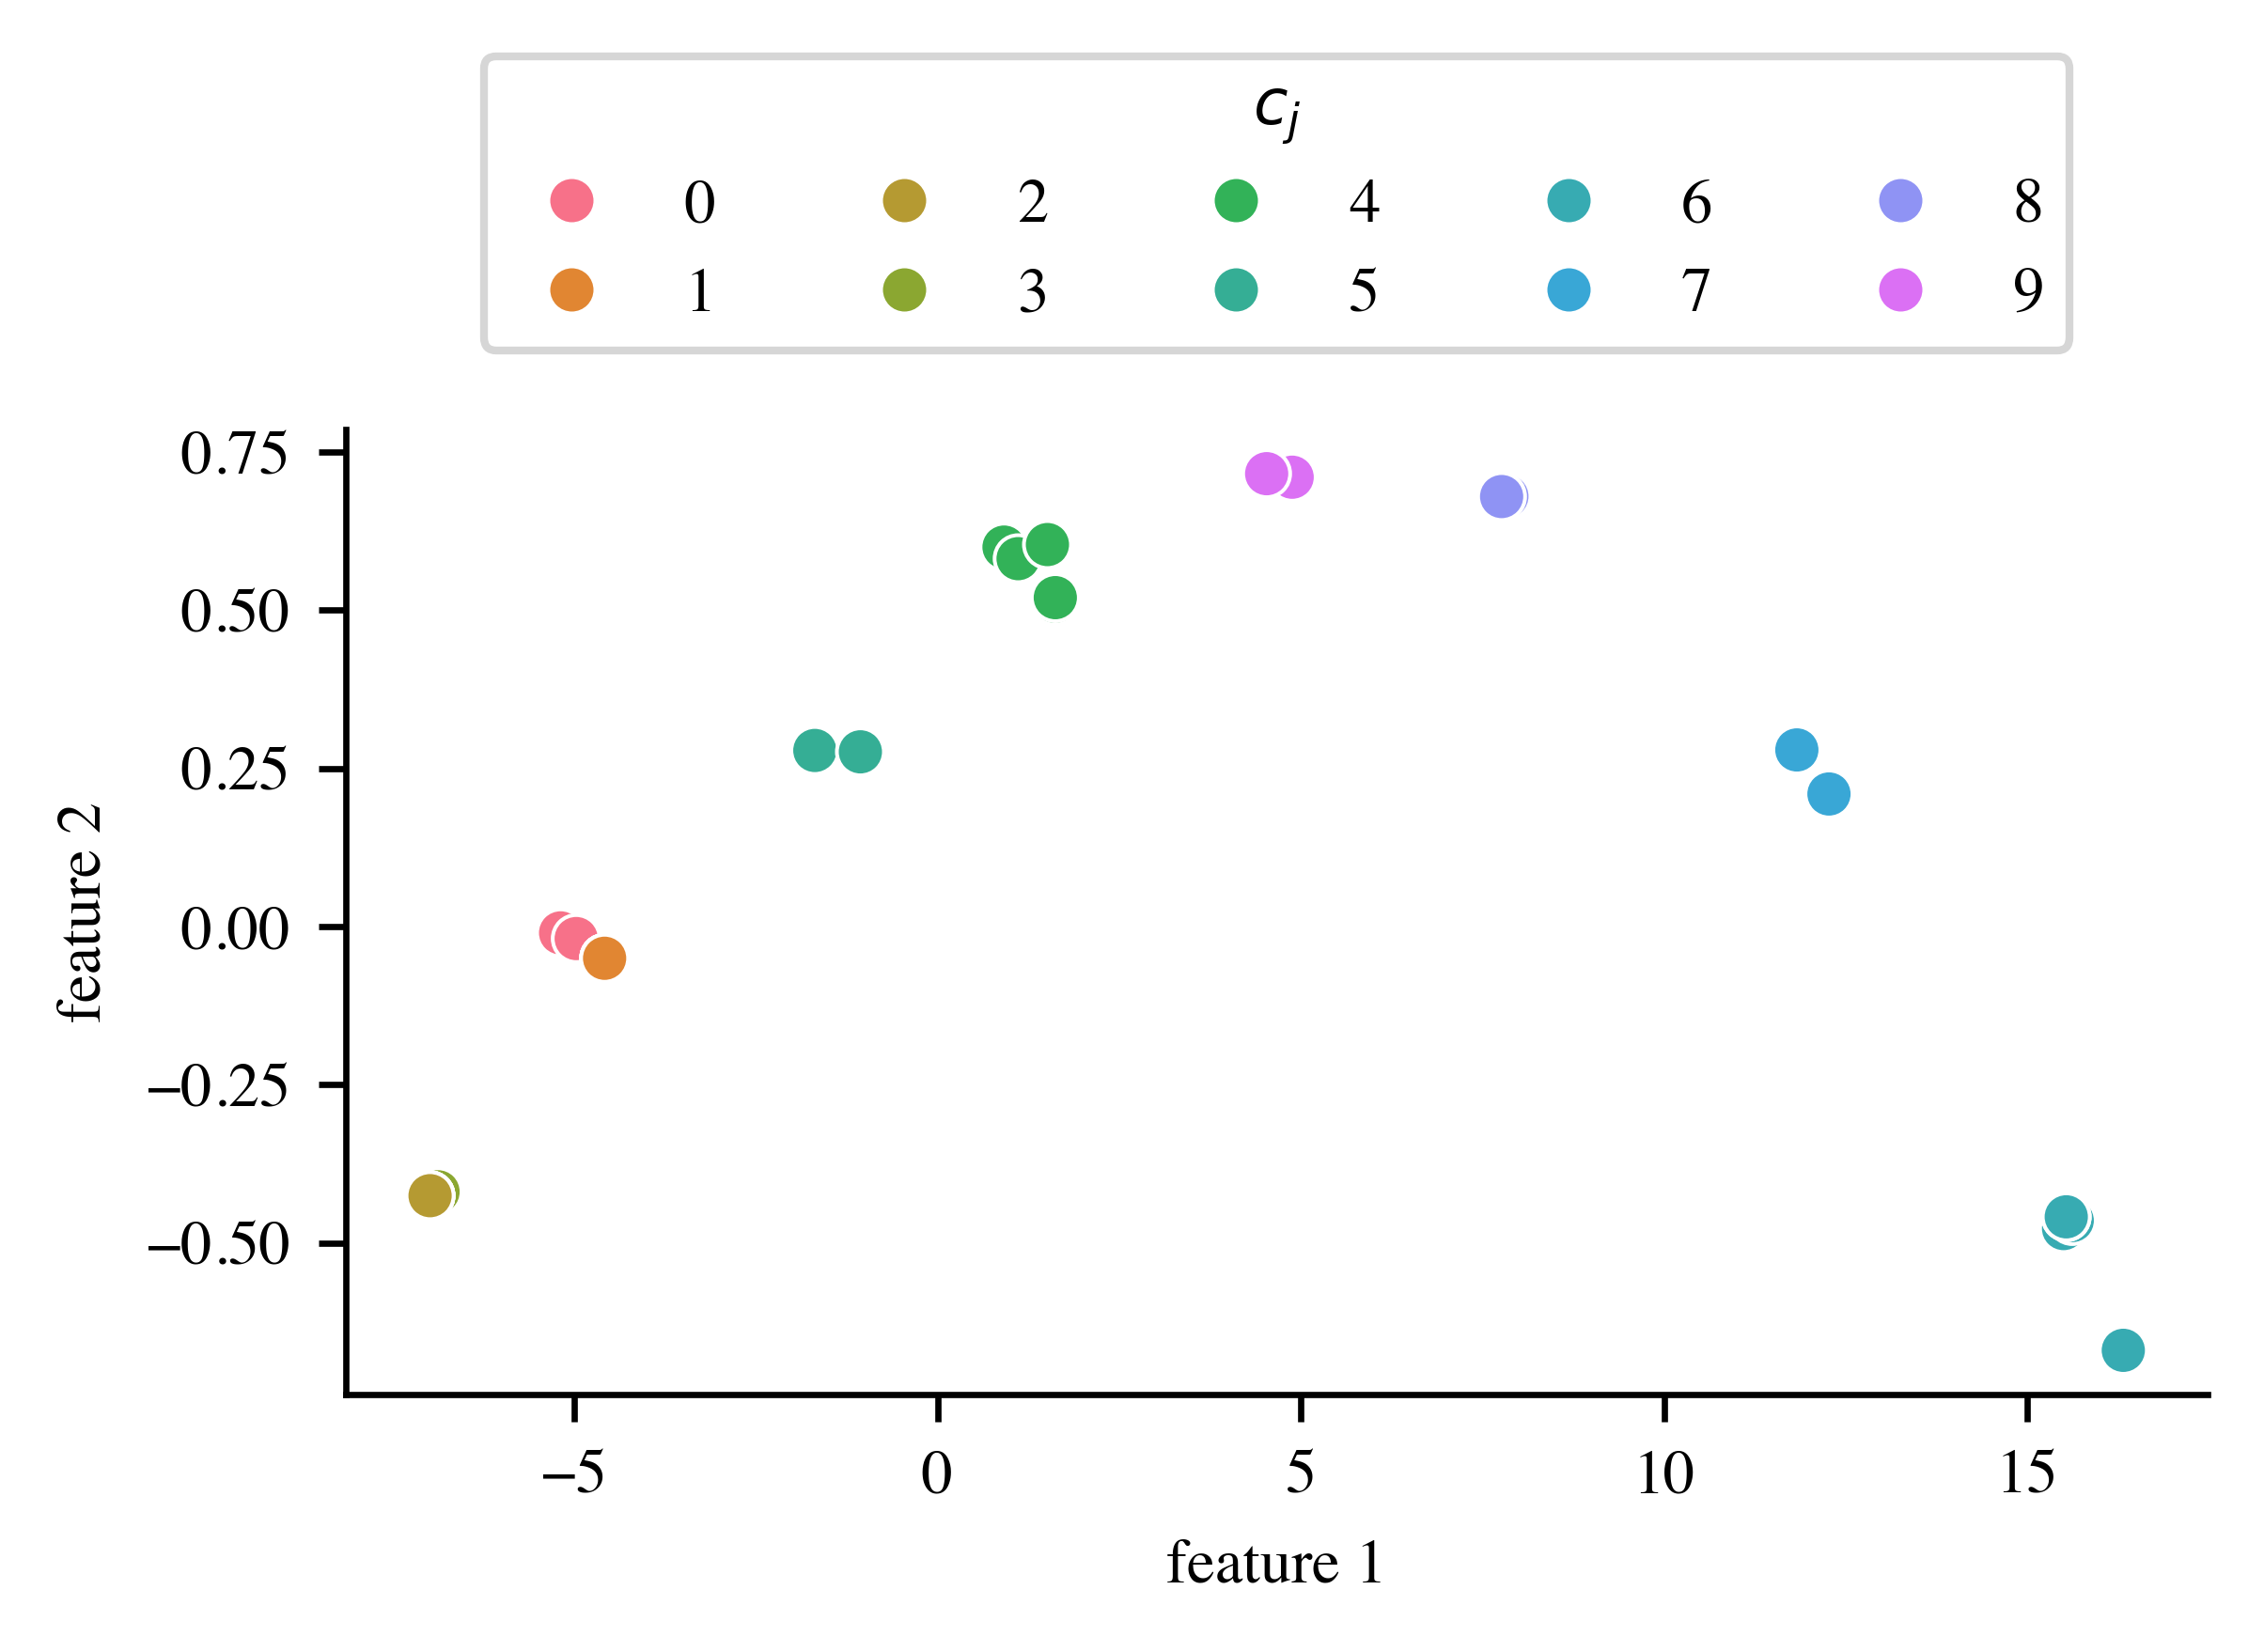

In [23]:
# cluster_data_embeds = [result_data_combinations[cid][1] for cid in result_data_combinations]
# cluster_data_embeds.pop(0)

pca_traj = PCA(n_components=2)
pca_traj_embeds = pca_traj.fit_transform(traj_embeddings)
plotting_data = {'feature 1': pca_traj_embeds[:, 0],
                 'feature 2': pca_traj_embeds[:, 1],
                 'cluster id': traj_cluster_labels}
df = pd.DataFrame(plotting_data)

plt.figure(figsize=(4,3))
data_ax = sns.scatterplot(x='feature 1',
                          y='feature 2',
                          hue='cluster id',
                          palette=palette[:len(clusters)],
                          data=df,
                          legend=True)
plt.legend(title = '$c_{j}$', loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=5)
# plt.legend(title = '$c_{j}$', loc='center left', bbox_to_anchor=(1., 0.7), ncol=2)
# for cid, _ in enumerate(cluster_data_embeds):
#     data_ax.text(pca_data_embeds[:, 0][cid],
#                  pca_data_embeds[:, 1][cid],
#                  str(cid),
#                  horizontalalignment='left',
#                  size='medium',
#                  color='black',
#                  weight='semibold')
plt.tight_layout()
plt.savefig('./traj_clustering_grid.pdf')
plt.show()

## Encode sets of trajectories (iii)

**(iii) Data Embedding**

Next we encode cells following the procedure explained in Algorithm 3 in paper. 

- Give the embedding trajectories as input
- Sum and Normalize these embedding trajectories
- Finally apply softmax.
- This is the final data embedding. A final step is done to construct the so-called complementary data embedding sets.
    - A of complementary data embedding sets are created by leaving out each time those embeddings belonging to the same class a part from the first which is comprised of all trajectories
    This way these resulting complementary sets have all the trajectories from the original data except those belonging to one cluster, which every time changes creating the number of cluster + 1 

In [24]:
# def get_data_embedding(traj_embeddings):
# #     return np.exp(np.abs(np.array(traj_embeddings).sum(axis=0)/100.))/np.sum(np.abs(np.exp(np.array(traj_embeddings).sum(axis=0)/100.)))
#     return np.exp(np.array(traj_embeddings).sum(axis=0)/len(clusters))/np.sum(np.exp(np.array(traj_embeddings).sum(axis=0)/len(clusters)))

def get_data_embedding(traj_embeddings):
    max_val = np.max(traj_embeddings)
    exp_values = np.exp(np.array(traj_embeddings) - max_val)
    return exp_values.sum(axis=0) / len(clusters) / np.sum(exp_values)


data_embedding = get_data_embedding(traj_embeddings)
data_embedding

array([5.3372751e-09, 3.5812486e-09, 6.2289791e-09, 8.8439753e-09,
       9.1808383e-09, 4.3295669e-09, 6.0687024e-09, 2.7803089e-09,
       2.6801821e-09, 3.3840175e-09, 3.5495573e-09, 3.2250222e-09,
       4.9002780e-09, 5.7551848e-09, 2.3211557e-09, 8.6248004e-09,
       8.3590814e-09, 5.4275131e-09, 2.5727662e-09, 9.2781214e-09,
       9.5608792e-09, 3.5265852e-09, 2.8791394e-09, 3.1925735e-09,
       4.7765241e-09, 3.9616643e-09, 2.9970197e-09, 3.2849781e-09,
       9.2187546e-09, 7.2731225e-09, 3.4711483e-09, 2.2625111e-09,
       6.0575851e-09, 2.4088738e-09, 5.8588656e-03, 9.4138816e-02,
       1.3755322e-08, 3.9791521e-09, 7.7942497e-09, 1.6752492e-09,
       1.5366054e-09, 1.8176003e-09, 9.3189990e-11, 1.7368407e-09,
       4.8552851e-09, 7.3530324e-09, 2.5918748e-10, 1.0977647e-08,
       1.3127541e-08, 6.7936443e-09, 4.4597797e-13, 1.9310132e-06,
       1.0449082e-07, 1.8783171e-09, 4.4003837e-10, 1.7686563e-09,
       4.6861763e-09, 2.8839819e-09, 1.7409766e-09, 8.2026060e

## Train models on different cluster combinations (iv)

**(iv) Training Explanation Policies**

Notice how we did not yet create the complementary datasets we talked about in previous section. 

That is because we are going to do it now, in the `forloop` down below. 

In the `generate_model` function and `dp` function we are doing what?
- `generate_model` is generating a transition model and a reward model based on the new trajectories.
- `dp` is instead creating the new explanation policy and returning also values and action_values.


In [25]:
transition_model, reward_model = generate_model(env, offline_data)
values, action_values, policy = dp(env, transition_model, reward_model, gamma=0.95, threshold=1e-4)

Inside the following loop, for every cluster, we are basically creating the complementary data embeddings and generating new transition model and reward models (through `generate_model`) used to create (through `dp`) the `explanation policy` for that specific complementary data embedding set and storing also the `action_values` (which are representative of the actions taken by the agent under this newly trained RL model with for each complementary data embedding set). These `action_values` are going to be used in step (v) Cluster attribution.


In [26]:
# Set the seeds
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

result_data_combinations = {0:(action_values, data_embedding)}
cluster_embeddings = {}

for cluster_id, cluster in enumerate(clusters):
    
    temp_data = []
    temp_traj_embeds = []
    temp_cluster_traj_embeds = []
    for traj_id, traj in enumerate(offline_data):
        if traj_id not in cluster:
            temp_data.append(offline_data[traj_id])
            temp_traj_embeds.append(traj_embeddings[traj_id])
        else:
            temp_cluster_traj_embeds.append(traj_embeddings[traj_id])
            
    # Generate the data embedding
    data_embedding_new = get_data_embedding(temp_traj_embeds)
    
    # Generate cluster embedding
    cluster_embedding = get_data_embedding(temp_cluster_traj_embeds)
    
    # Train an agent on the new data
    transition_model_new, reward_model_new = generate_model(env, temp_data)
    values_new, action_values_new, policy_new = dp(env,
                                                   transition_model_new,
                                                   reward_model_new,
                                                   gamma=0.95,
                                                   threshold=1e-4)
    
    # Collect the data embedding and the trajectory
    result_data_combinations[cluster_id + 1] = (action_values_new, data_embedding_new)
    cluster_embeddings[cluster_id] = cluster_embedding

## Generate attributions (v)

**(v) Cluster Attribution**

Final step of algorithm:
For every state of the agent we compute distance between original action values (of the initial RL agent) and the new `action_values` computed before. 
We do this for every element of `result_data_combinations` dictionary, which is comprised of all the complementary data embedding sets for each cluster and the new sets of actions from the new trained agent for each cluster. 
It is a dict of key and a tuple made of (action_values_new, data_embedding_new) as value. 

<!-- That is why `result_data_combinations[data_combination_id][0].shape` = 64  `result_data_combinations[data_combination_id][1].shape` = (49 (7x7), 4) -->

If the two sets of actions are different we compare them through the `wasserstein_distance` and store this value.

We then save the cluster with smallest distance into `responsible_data_combination` by argsorting on the distances and selecting the zero-th element. 

If in that specific state the value corresponding to the smallest distance is either 1e9 or 0 then it means that either that complementary set caused the same state_actions as in the original data (1e9). 
The point is if these are the smallest distance values then using different dataset has not caused any change in the behaviour of the agent. Meaning that state action has not been influenced by using a complementary data embedding set instead of original data. Thus we can go on looking for other states in order to find smallest data distance. 

The printed results show only those states which are indeed affected by the change in data. 

The numbers shown into `Responsible trajectory id` represent the trajectories belonging to the cluster which has influenced the most the trajectory in that state, which corresponds with the one with less distance. 

There are some prints in the following cell to help you understand. ##



In [27]:
# Set the seeds
# random.seed(0)
# np.random.seed(0)
# torch.manual_seed(0)

attributions = []

for state in range(np.prod(env.dim)):
    
    if (state//env_width, state%env_width) in env.terminals:
        continue
    
    print(state)
    # print(action_values.shape)
    orig_state_action_values = action_values[state]

    
    # print(orig_state_action_values)
    orig_opt_state_actions = np.where(orig_state_action_values == np.max(orig_state_action_values))[0]
    # print(orig_opt_state_actions)

    distances = []
    new_actions = []
    for data_combination_id, (action_values_new, data_embedding_new) in result_data_combinations.items():
        new_state_action_values = action_values_new[state]
        # print("data_comb_id", data_combination_id)
        # print(action_values_new[data_combination_id])
        # print("state", state)
        # print(action_values_new[state])

        new_opt_state_actions = np.where(new_state_action_values == np.max(new_state_action_values))[0]
        # print(new_state_action_values)

        if list(new_opt_state_actions) != list(orig_opt_state_actions):
            w_d = wasserstein_distance(data_embedding, data_embedding_new)
        else:
            w_d = 1e9
        
        distances.append(w_d)
        new_actions.append(new_opt_state_actions)

    ## argsorting on the distances and selecting the zero-th element. This corresponds to the smallest distance cluster for that state for every complementary data embedding set.
    responsible_data_combination = np.argsort(distances)[0]
    # print(distances)


    ## if you want print these two, so that you can see the distances and the smallest distance cluster. 
    # print(distances, distances[responsible_data_combination], responsible_data_combination)
    ## if you print this, you understand how trajectories are grouped and why `Responsible trajectory id` is showing what it is showing.
    # print(clusters)


    if distances[responsible_data_combination] == 1e9 or distances[responsible_data_combination] == 0:
        continue
    
    print('-'*10)
    print(f'State - {state%env_width + 1, state//env_width + 1}')
    print(f'Distance - {distances[responsible_data_combination]}')
    print(f'Original Actions -{[action_dict[orig_action] for orig_action in orig_opt_state_actions]}')
    print(f'New Action - {[action_dict[new_action] for new_action in new_actions[responsible_data_combination]]}')

    print(f'Responsible data combination - data id {responsible_data_combination}')
    print(f'Responsible trajectory id {clusters[responsible_data_combination - 1]}')
    if len(clusters[responsible_data_combination - 1]):
        cid_list = list(range(len(clusters)))
        cid_list.pop(responsible_data_combination - 1)
        alternate_cid = np.random.choice(cid_list)
        attributions.append({
            'state' : (state%env_width + 1, state//env_width + 1),
            'orig_act': [action_dict[orig_action] for orig_action in orig_opt_state_actions],
            'new_act': [action_dict[new_action] for new_action in new_actions[responsible_data_combination]],
            'attributed_trajs':clusters[responsible_data_combination - 1],
            'random_baseline_trajs': list(np.random.randint(0, len(offline_data), 5)),
            'alternate_cluster_trajs': clusters[alternate_cid - 1],
            'responsible_cluster': responsible_data_combination - 1
        })
#         for traj in clusters[responsible_data_combination - 1]:
#             env.plot_traj(offline_data[traj])
    print('-'*10)


tracker.stop()

[codecarbon INFO @ 15:30:50] Energy consumed for RAM : 0.001173 kWh. RAM Power : 12.0 W
[codecarbon INFO @ 15:30:50] Energy consumed for all CPUs : 0.004153 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:30:50] 0.005326 kWh of electricity used since the beginning.


0
----------
State - (1, 1)
Distance - 1.2889763917922874e-08
Original Actions -['RIGHT']
New Action - ['LEFT', 'UP', 'RIGHT', 'DOWN']
Responsible data combination - data id 7
Responsible trajectory id [42, 43, 44, 45, 46, 47, 48, 49]
----------
1
----------
State - (2, 1)
Distance - 1.2889763917922874e-08
Original Actions -['RIGHT']
New Action - ['LEFT', 'UP', 'RIGHT', 'DOWN']
Responsible data combination - data id 7
Responsible trajectory id [42, 43, 44, 45, 46, 47, 48, 49]
----------
2
3
4
5
7
----------
State - (1, 2)
Distance - 1.2889763917922874e-08
Original Actions -['UP']
New Action - ['LEFT', 'UP', 'RIGHT', 'DOWN']
Responsible data combination - data id 7
Responsible trajectory id [42, 43, 44, 45, 46, 47, 48, 49]
----------
8
9
10
11
----------
State - (5, 2)
Distance - 1.2889763917922874e-08
Original Actions -['RIGHT']
New Action - ['UP']
Responsible data combination - data id 7
Responsible trajectory id [42, 43, 44, 45, 46, 47, 48, 49]
----------
12
13
14
----------
State - 

0.002070151380832795

In [28]:
attributions

[{'state': (1, 1),
  'orig_act': ['RIGHT'],
  'new_act': ['LEFT', 'UP', 'RIGHT', 'DOWN'],
  'attributed_trajs': [42, 43, 44, 45, 46, 47, 48, 49],
  'random_baseline_trajs': [2, 8, 10, 5, 38],
  'alternate_cluster_trajs': [27, 28, 29, 30, 31, 32, 33, 34, 35],
  'responsible_cluster': 6},
 {'state': (2, 1),
  'orig_act': ['RIGHT'],
  'new_act': ['LEFT', 'UP', 'RIGHT', 'DOWN'],
  'attributed_trajs': [42, 43, 44, 45, 46, 47, 48, 49],
  'random_baseline_trajs': [36, 1, 53, 59, 36],
  'alternate_cluster_trajs': [42, 43, 44, 45, 46, 47, 48, 49],
  'responsible_cluster': 6},
 {'state': (1, 2),
  'orig_act': ['UP'],
  'new_act': ['LEFT', 'UP', 'RIGHT', 'DOWN'],
  'attributed_trajs': [42, 43, 44, 45, 46, 47, 48, 49],
  'random_baseline_trajs': [5, 38, 35, 24, 49],
  'alternate_cluster_trajs': [27, 28, 29, 30, 31, 32, 33, 34, 35],
  'responsible_cluster': 6},
 {'state': (5, 2),
  'orig_act': ['RIGHT'],
  'new_act': ['UP'],
  'attributed_trajs': [42, 43, 44, 45, 46, 47, 48, 49],
  'random_baseline

In [29]:
results_save_dir = './gridworld_results/grid_7by7/'
if not os.path.exists(results_save_dir):
    os.makedirs(results_save_dir)


# for traj_id, traj in enumerate(offline_data):
#     env.plot_traj(traj, path=os.path.join(results_save_dir, 'traj_' + str(traj_id) + '.png'))


In [30]:
class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

In [31]:
# Data to save
data_to_be_saved = [
    {
        'attributions' : attributions,
    }
]

dumped = json.dumps(data_to_be_saved, cls=NumpyEncoder)

with open(os.path.join(results_save_dir, 'attribution_results.json'), 'w') as f:
    json.dump(dumped, f)

## Reproducing Figure Results from Paper


### Human Study Plots

In [32]:
state1 = (1,1)
state2 = (5, 2)

state1_dict = [el for el in attributions if el['state'] == state1]
state2_dict = [el for el in attributions if el['state'] == state2]

state1_dict = state1_dict[0]
state2_dict = state2_dict[0]

state1_dict, state2_dict

({'state': (1, 1),
  'orig_act': ['RIGHT'],
  'new_act': ['LEFT', 'UP', 'RIGHT', 'DOWN'],
  'attributed_trajs': [42, 43, 44, 45, 46, 47, 48, 49],
  'random_baseline_trajs': [2, 8, 10, 5, 38],
  'alternate_cluster_trajs': [27, 28, 29, 30, 31, 32, 33, 34, 35],
  'responsible_cluster': 6},
 {'state': (5, 2),
  'orig_act': ['RIGHT'],
  'new_act': ['UP'],
  'attributed_trajs': [42, 43, 44, 45, 46, 47, 48, 49],
  'random_baseline_trajs': [50, 9, 55, 4, 49],
  'alternate_cluster_trajs': [55],
  'responsible_cluster': 6})

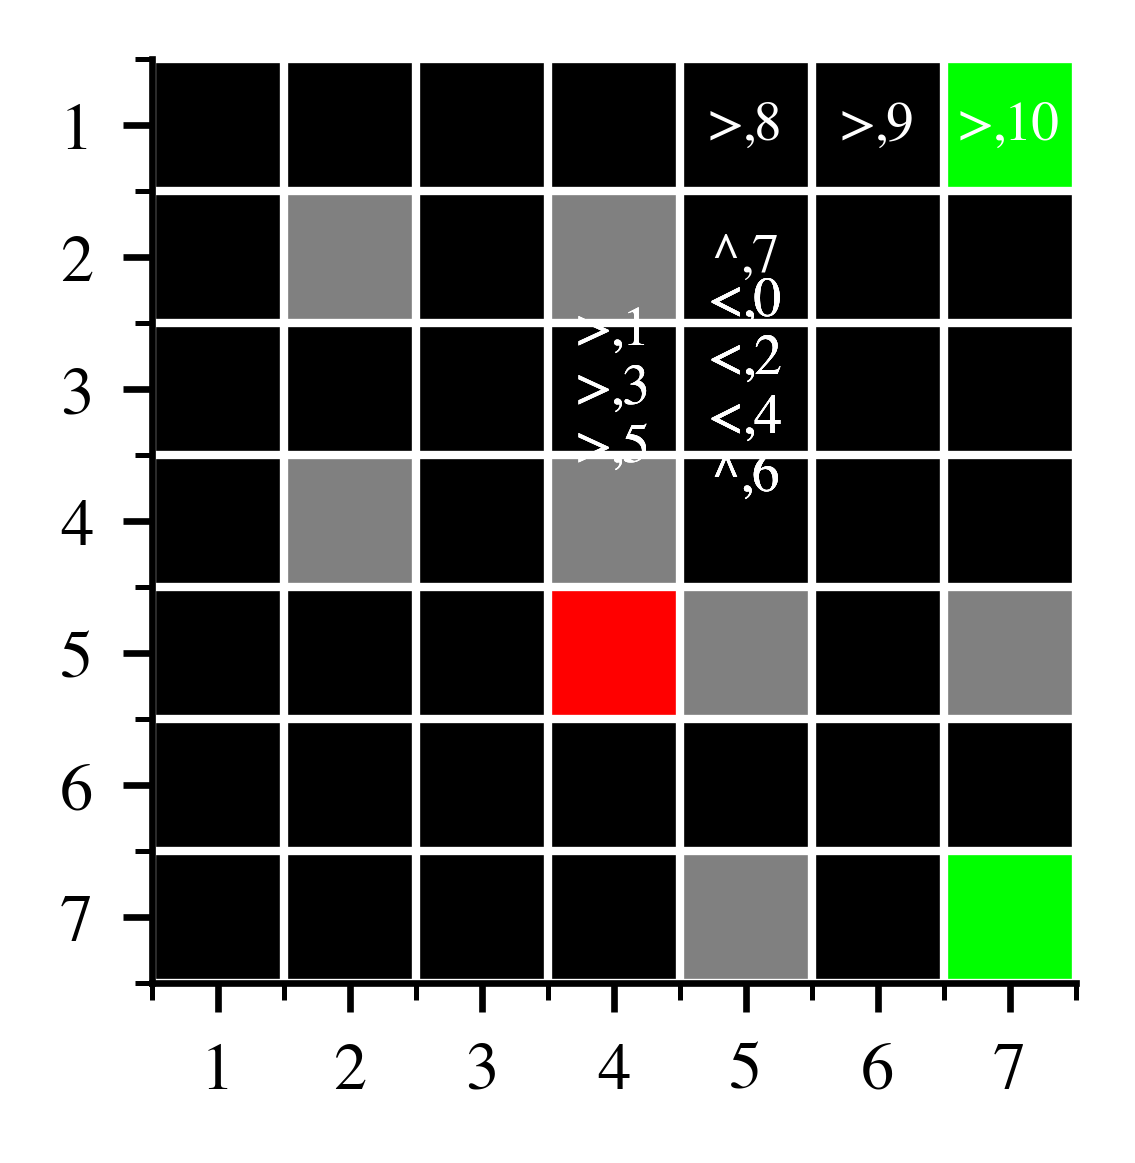

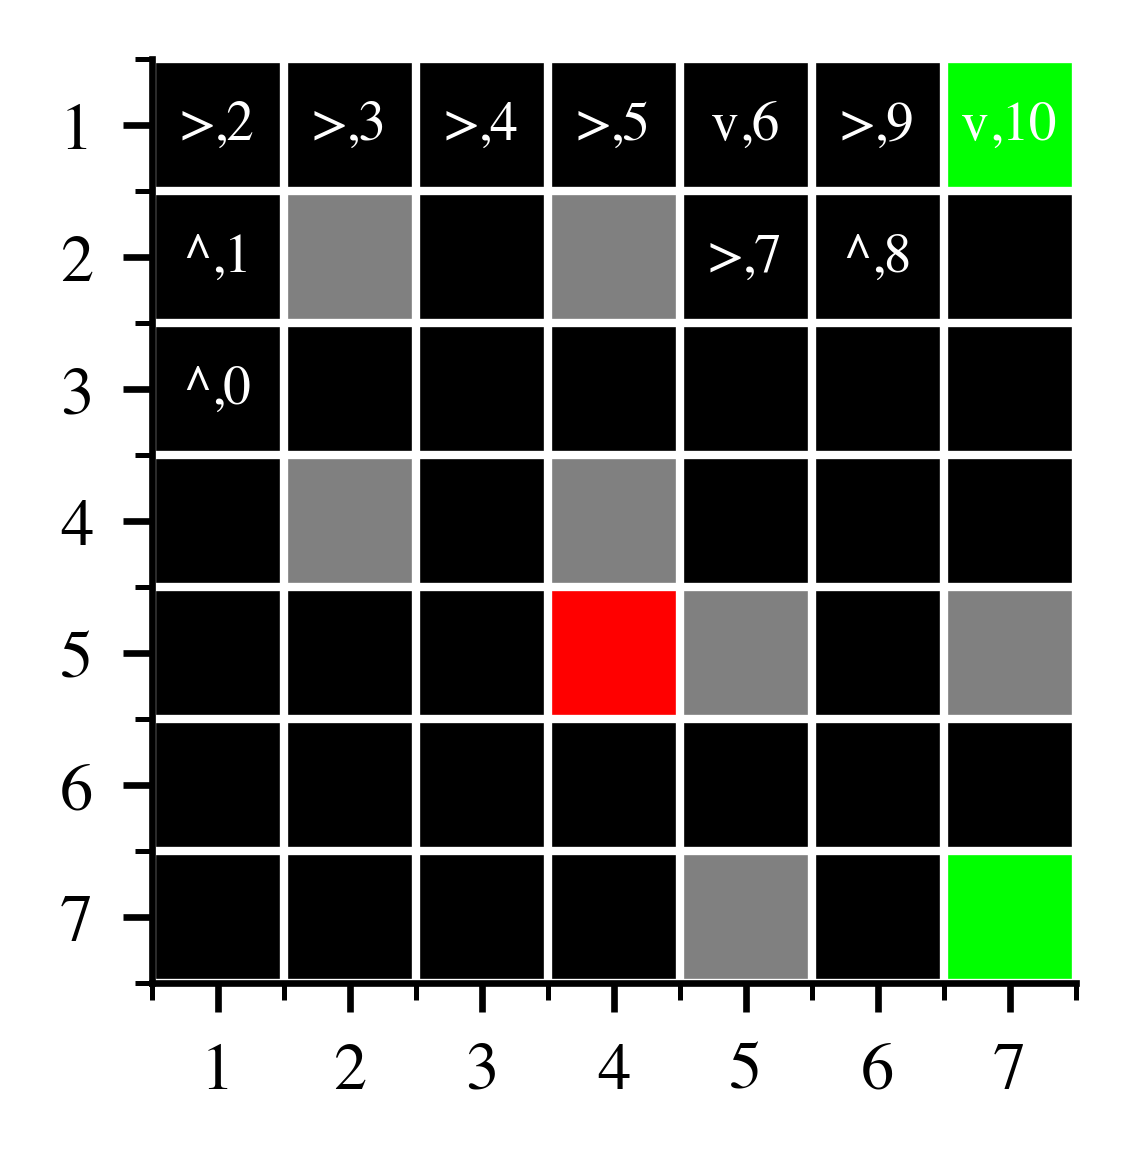

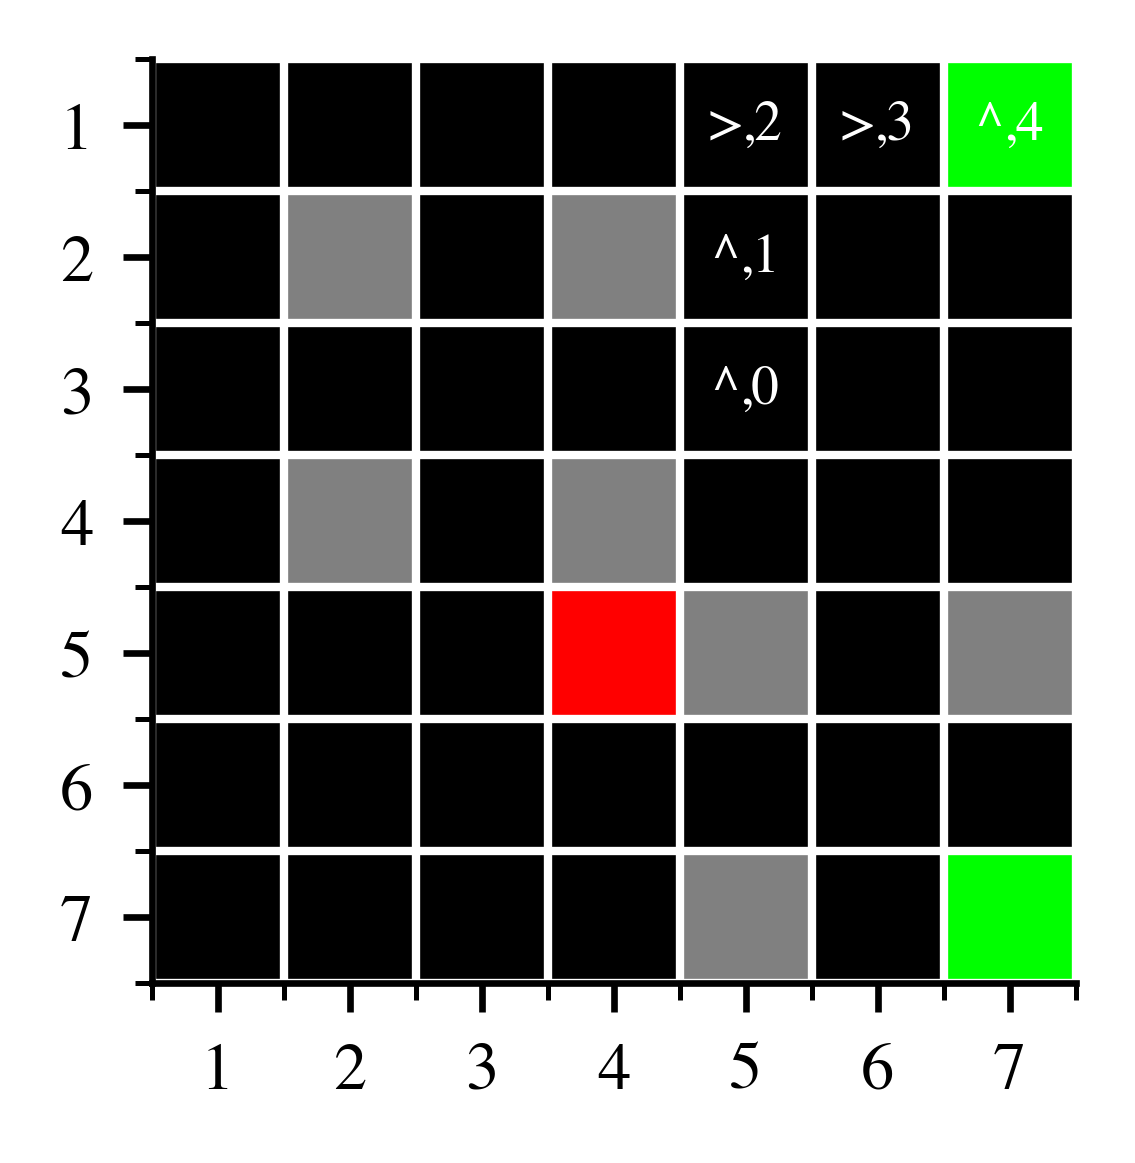

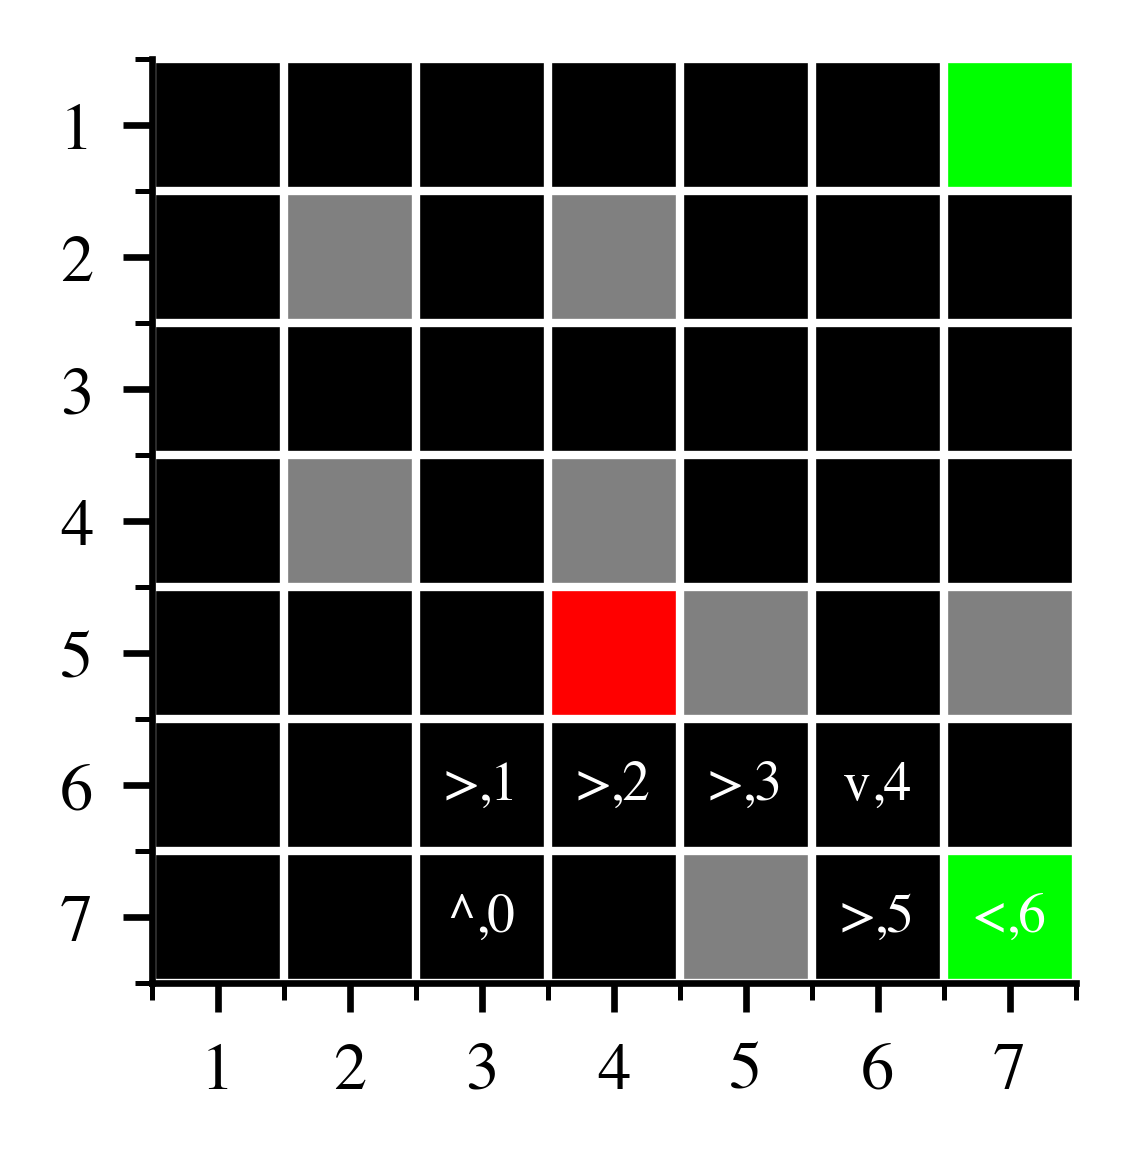

In [33]:
for i in  range(2):
    env.plot_traj(offline_data[state1_dict['attributed_trajs'][i]])


env.plot_traj(offline_data[state1_dict['random_baseline_trajs'][3]])
env.plot_traj(offline_data[state1_dict['alternate_cluster_trajs'][3]])


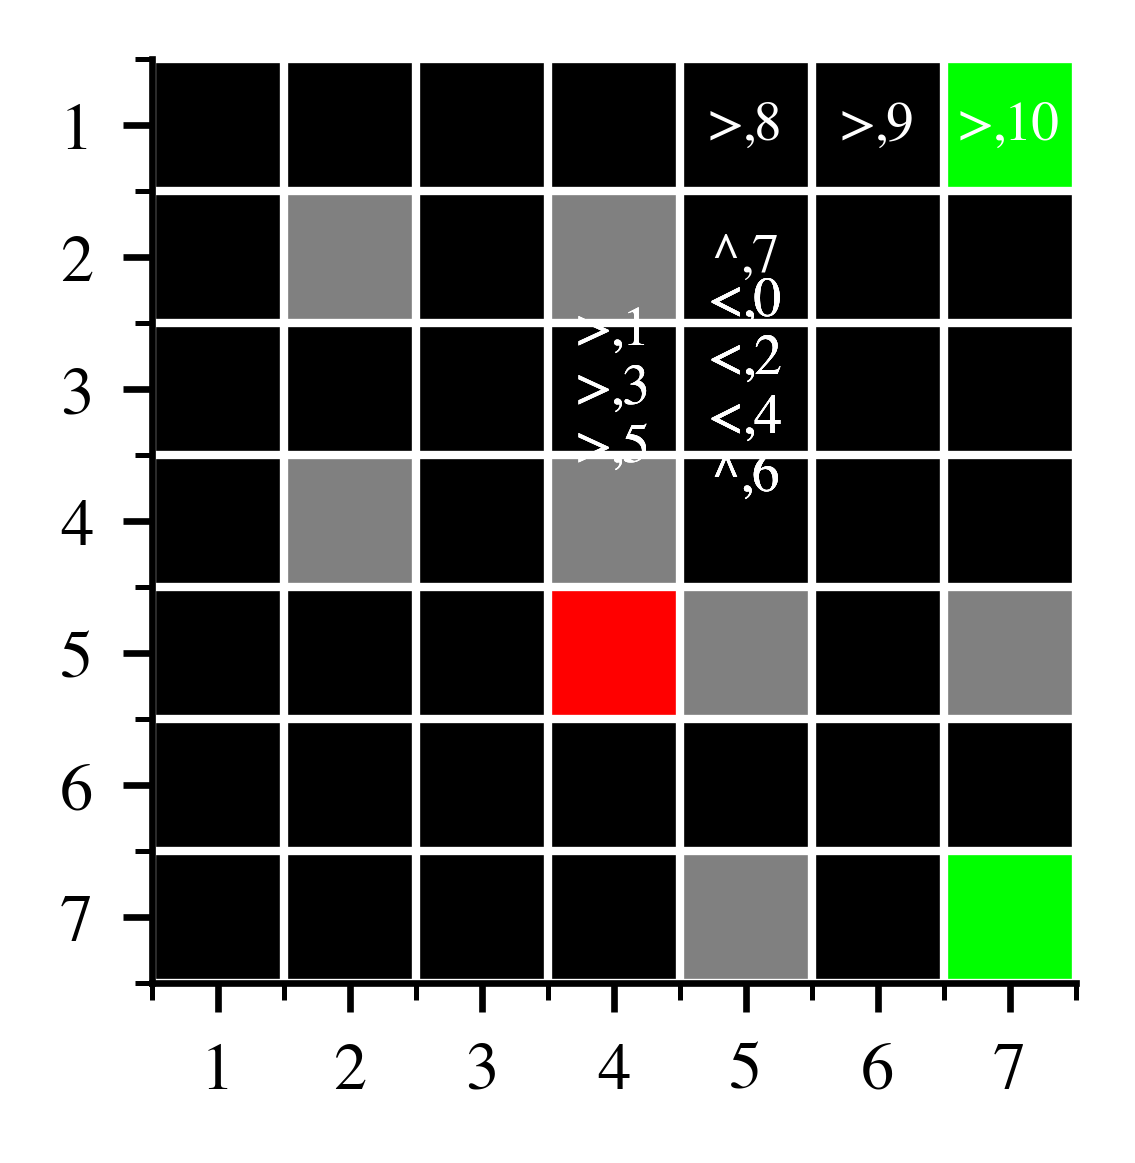

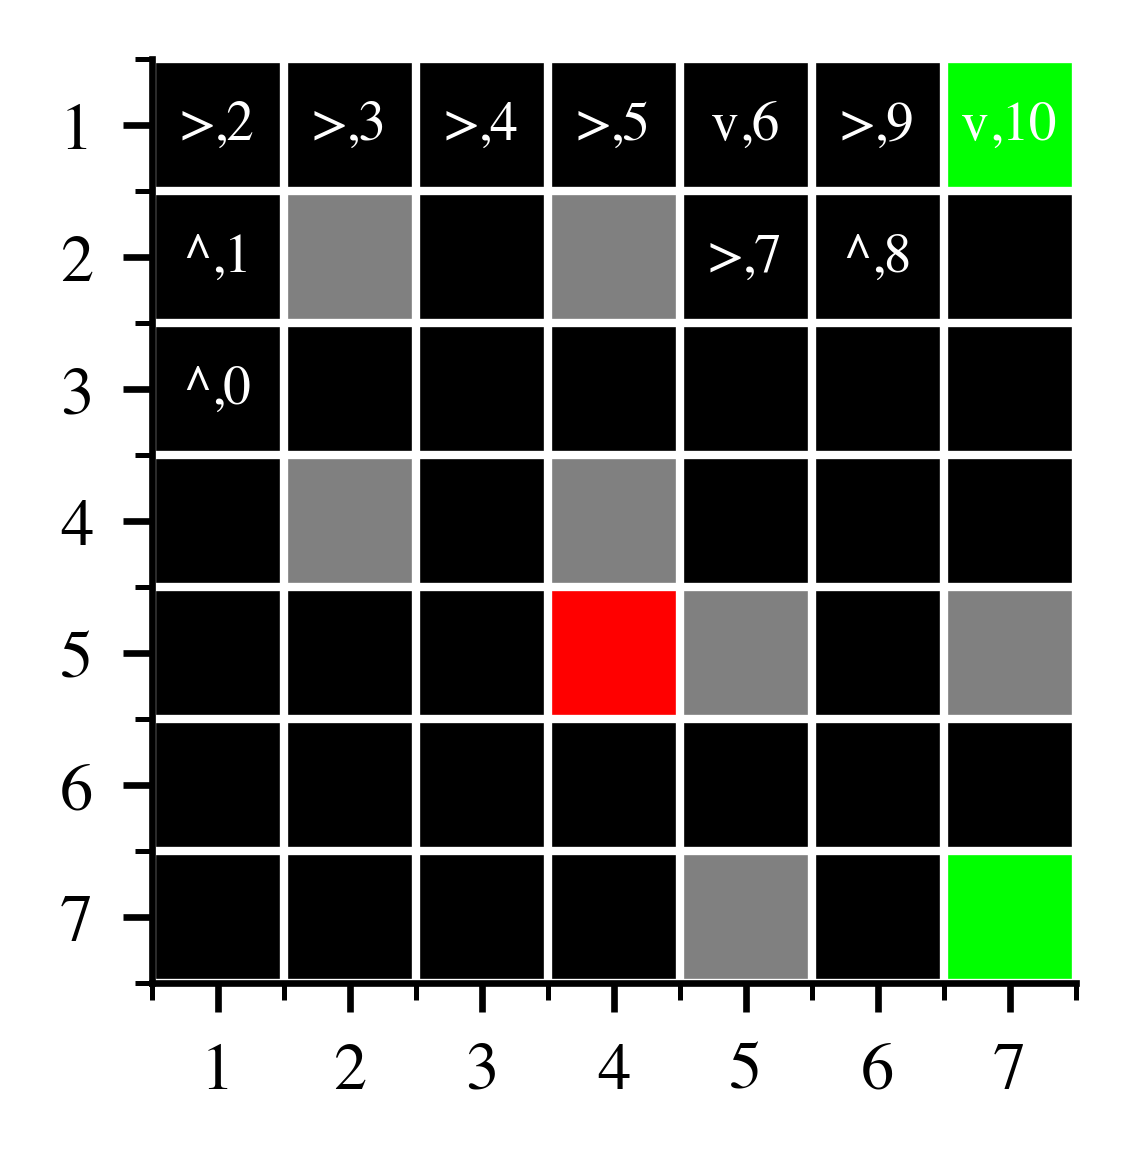

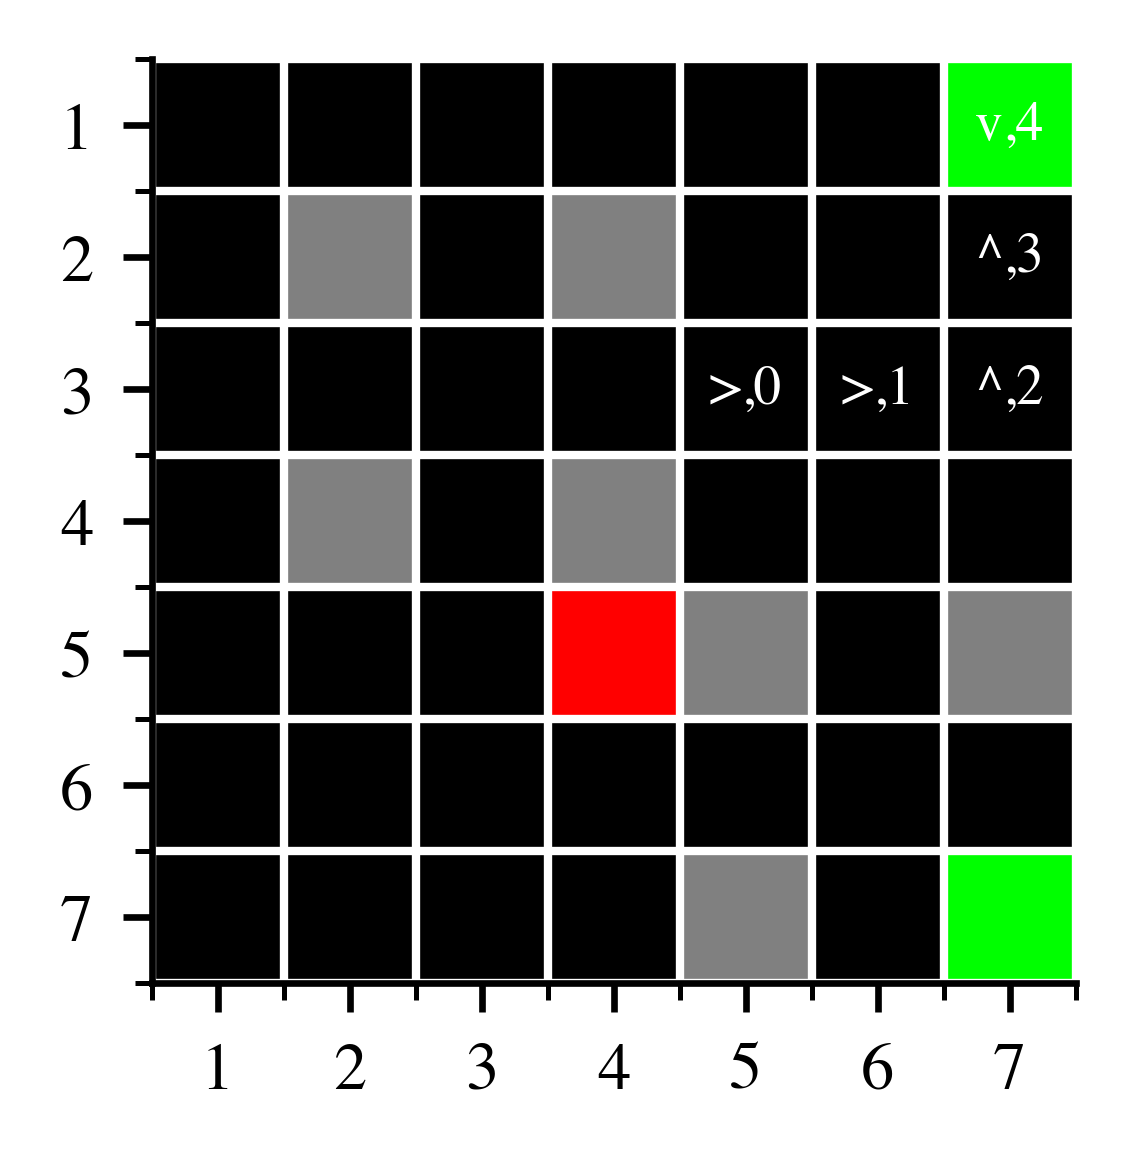

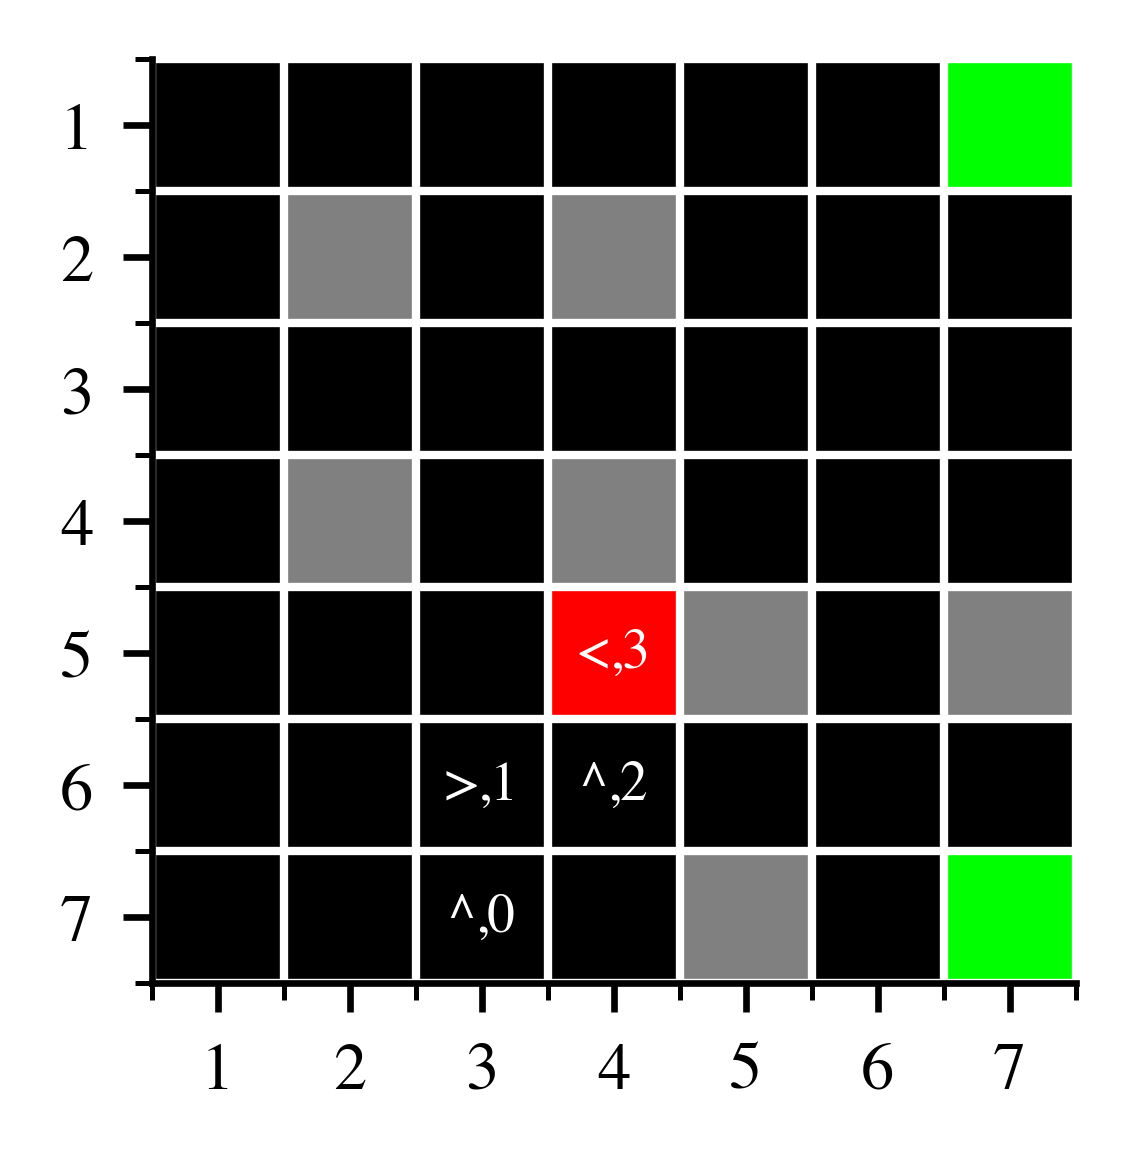

In [34]:
for i in  range(2):
    env.plot_traj(offline_data[state2_dict['attributed_trajs'][i]])

env.plot_traj(offline_data[state2_dict['random_baseline_trajs'][1]])
env.plot_traj(offline_data[state2_dict['alternate_cluster_trajs'][0]])


Given the results obtained through intriveiws we obtained the following data:
1. The first experiment had a total amount of attributed to each: 
`Alternate: 2, Attr. traj1: 18, Random 12, Attr. traj2: 9`
2. The second experiment had a total amount of attributed to each: 
`Alternate: 1, Attr. traj1: 10, Attr. traj2: 15, Random: 15`


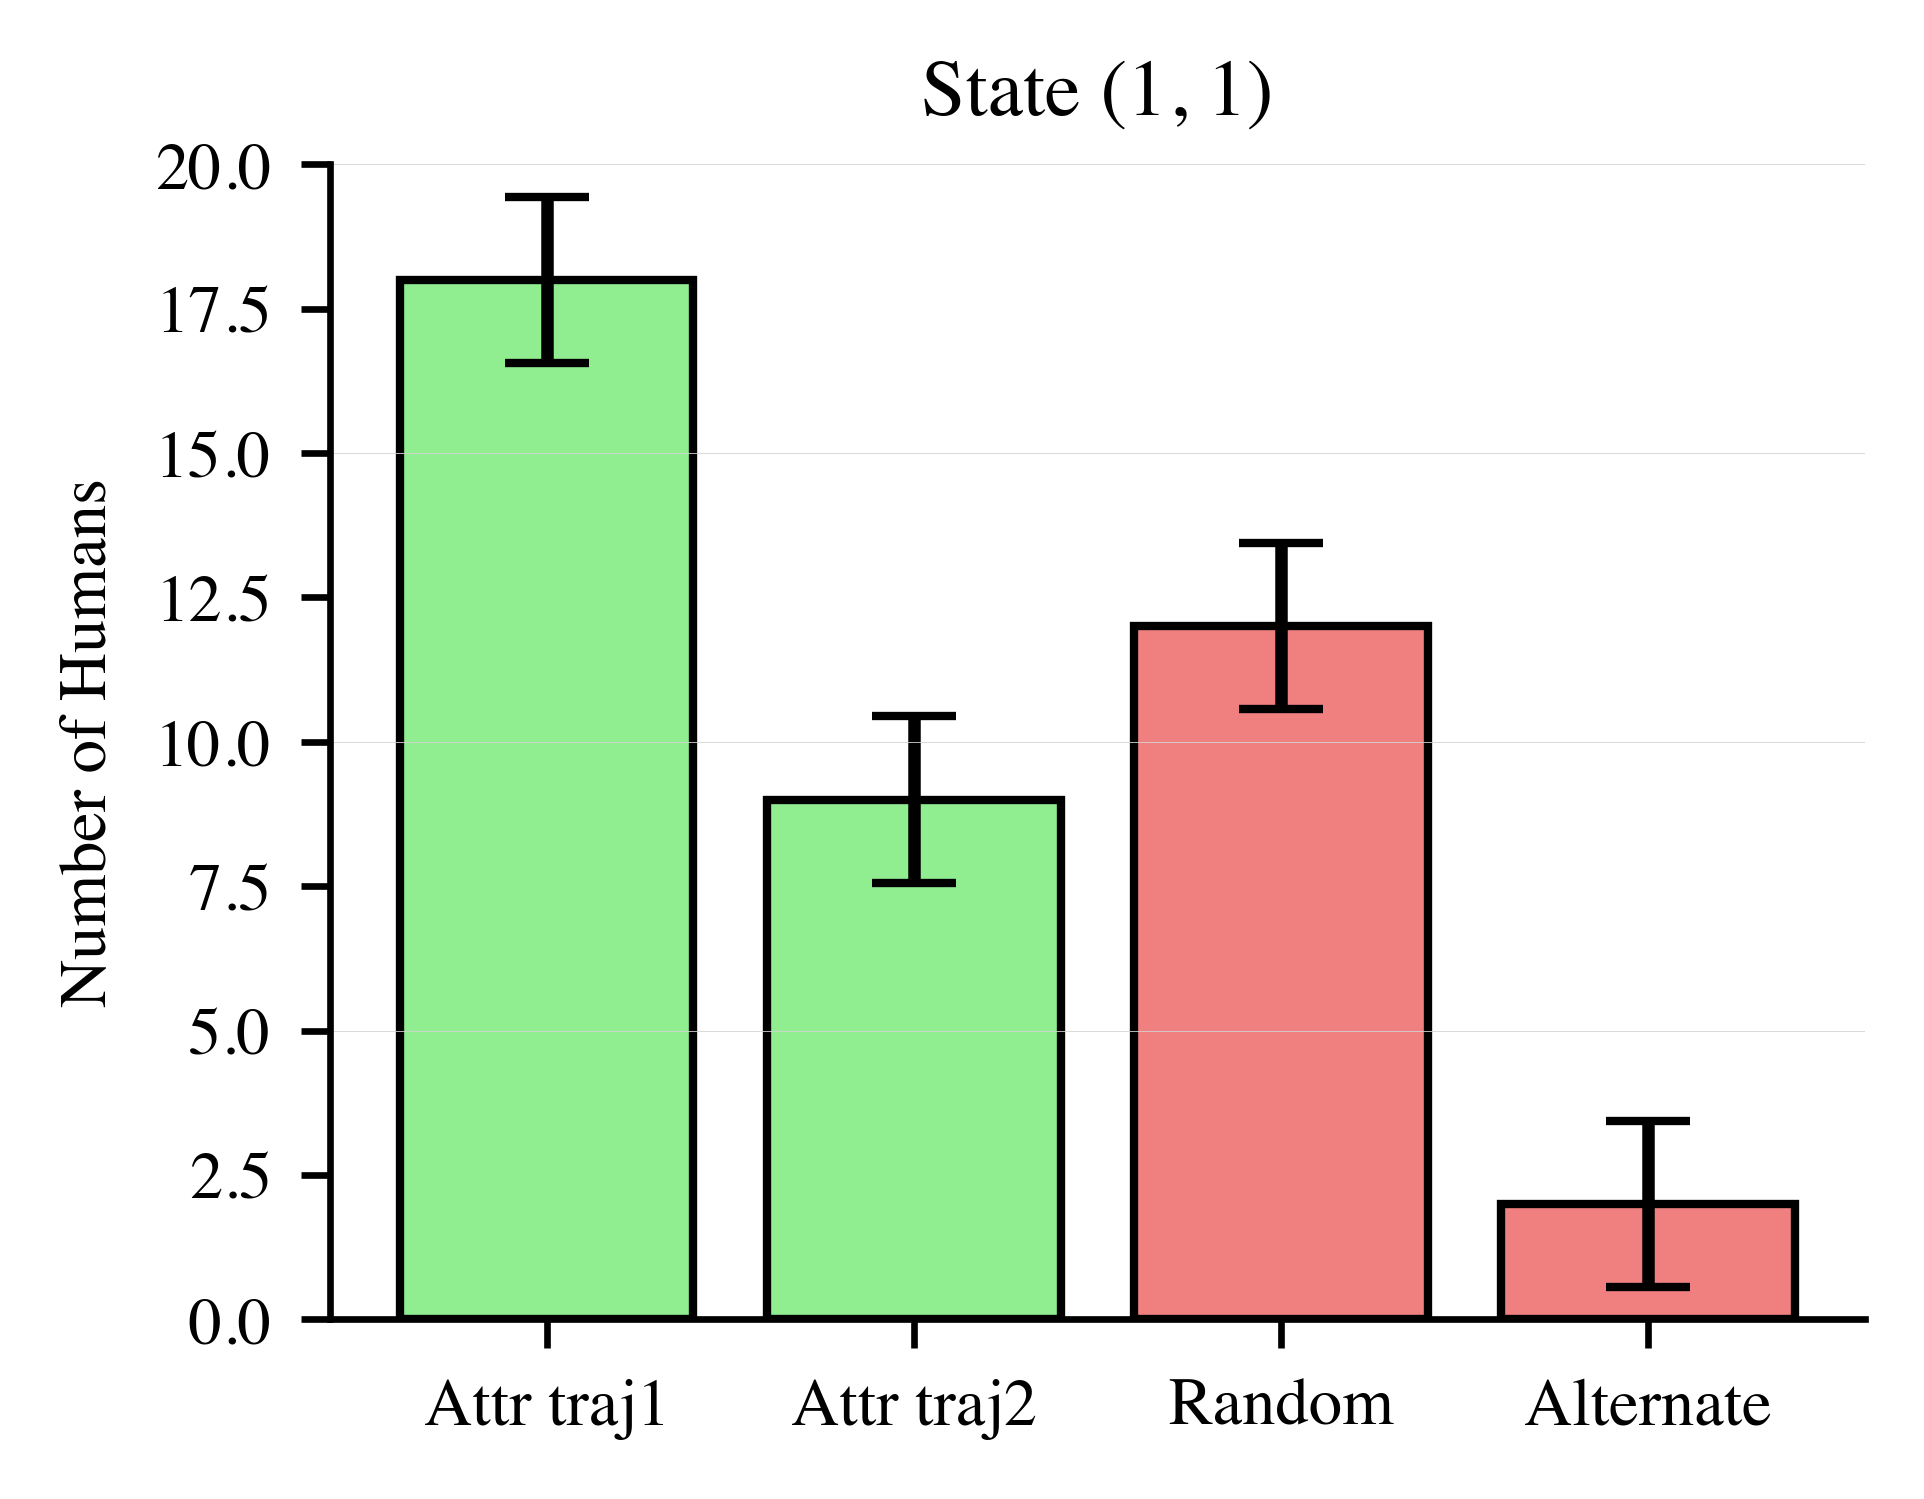

In [35]:
## plot for state (1,1) experiments
data = [18, 9, 12, 2]
x_labels = ['Attr traj1', 'Attr traj2', 'Random', 'Alternate']
colors = ['lightgreen', 'lightgreen', 'lightcoral', 'lightcoral']

fig, ax = plt.subplots()
ax.bar(x_labels, data, yerr=np.std(data)/len(data), capsize=5, color=colors, edgecolor='black')

plt.ylim(0, max(data) + 2) 

for y in range(0, max(data) + 5, 5):    
    plt.axhline(y=y, color='lightgrey', linestyle='-', linewidth=0.1)



# Set labels and title
plt.xlabel('')
plt.ylabel('Number of Humans')
plt.title('State (1, 1)')


# Show the plot
plt.show()


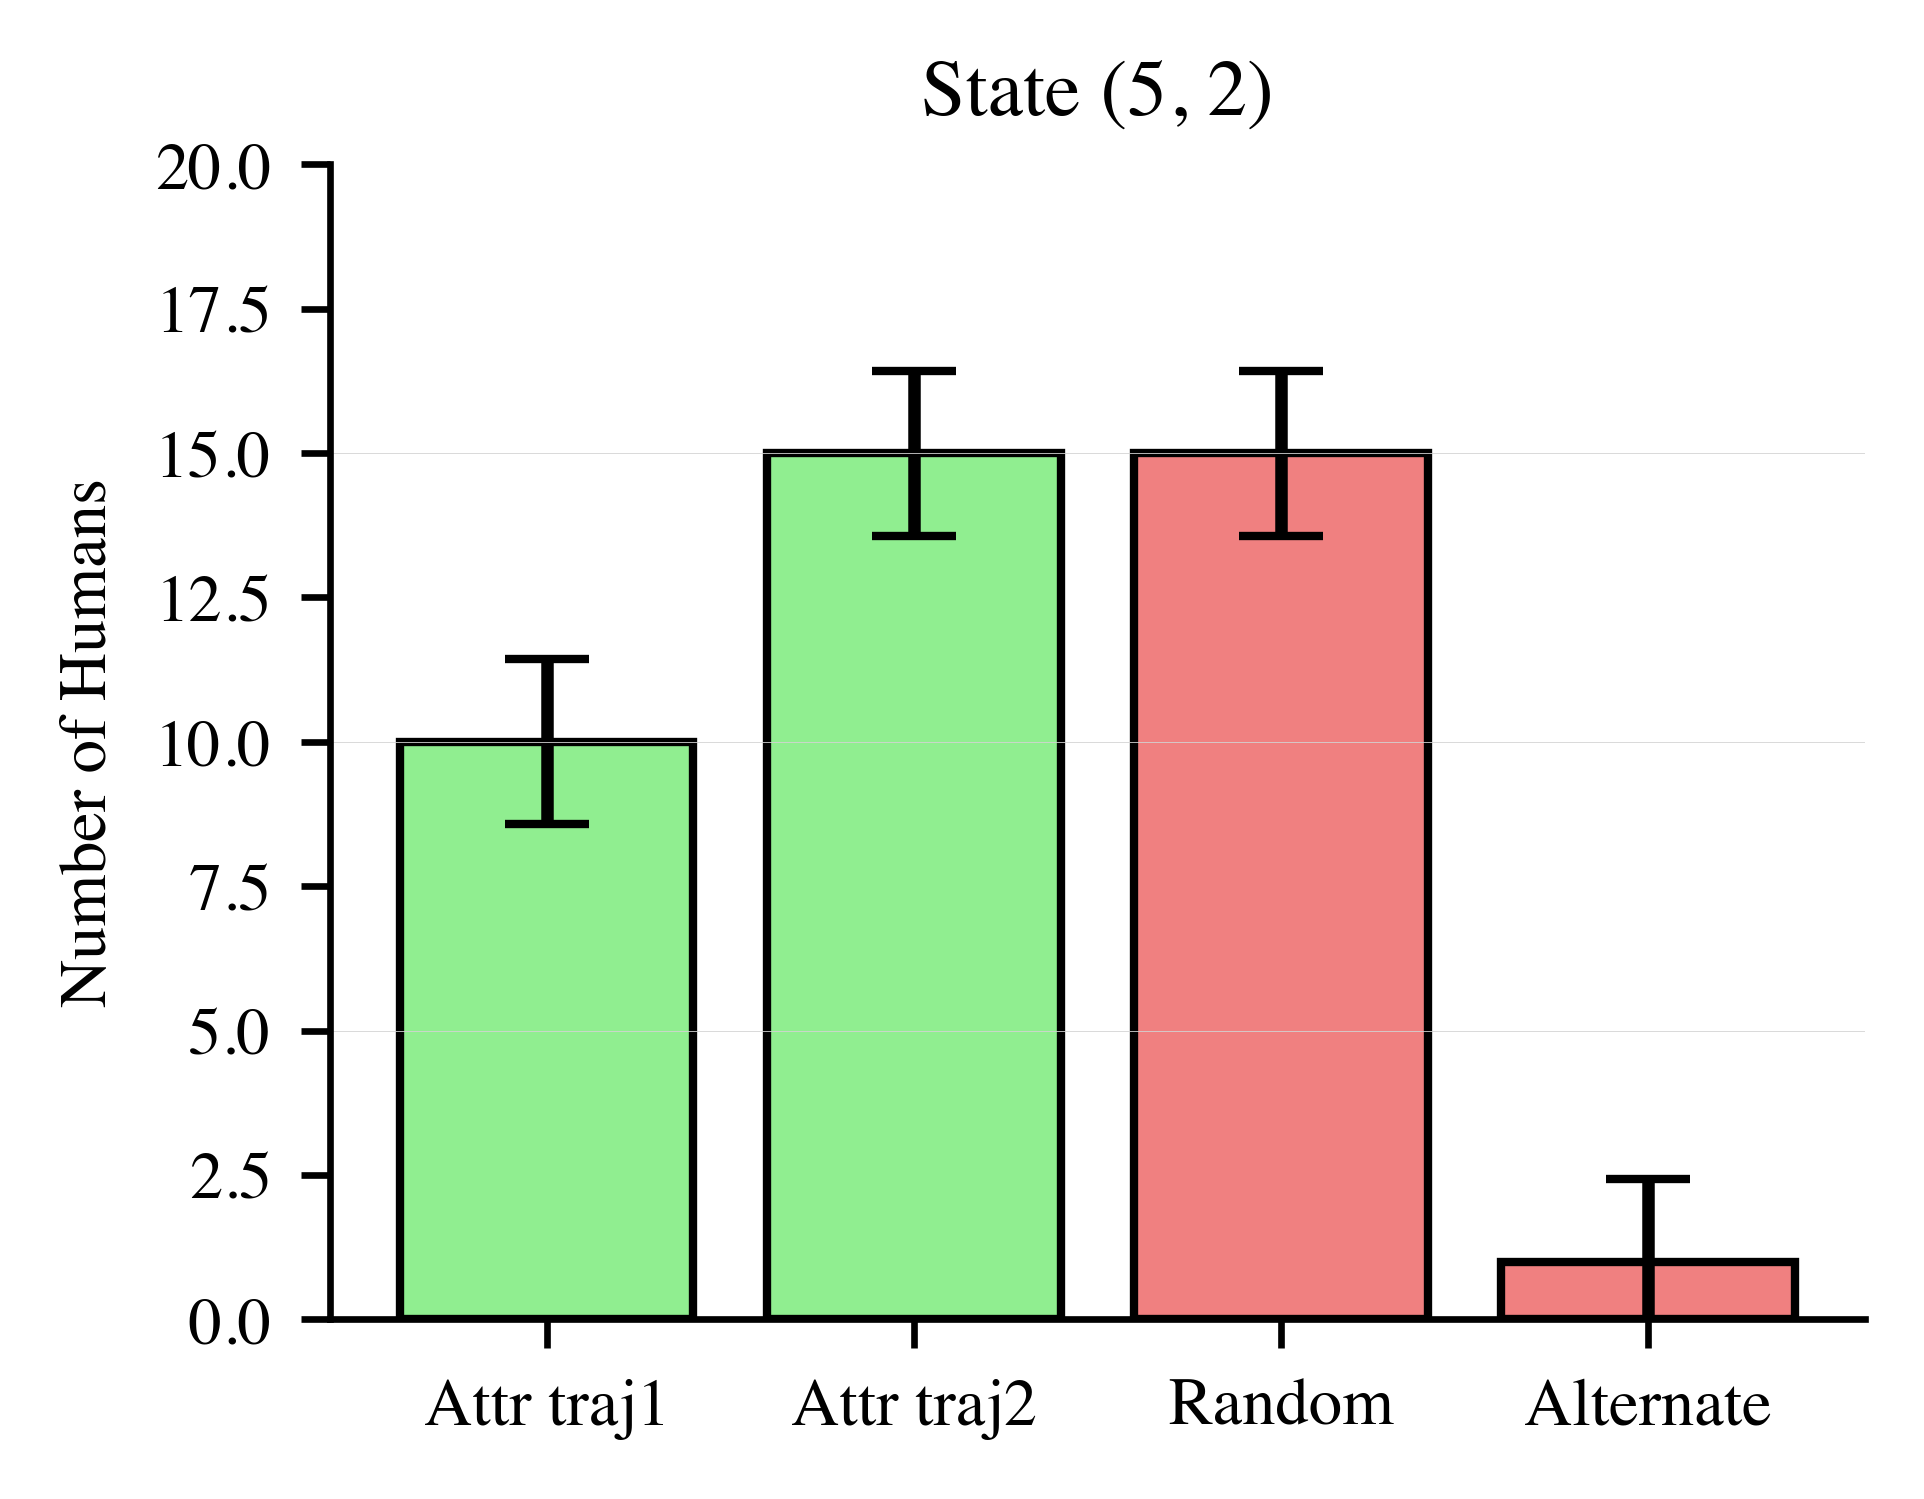

In [36]:
## plot for state (5,2) experiments
data = [10, 15, 15, 1]
x_labels = ['Attr traj1', 'Attr traj2', 'Random', 'Alternate']
colors = ['lightgreen', 'lightgreen', 'lightcoral', 'lightcoral']

fig, ax = plt.subplots()
ax.bar(x_labels, data, yerr=np.std(data)/len(data), capsize=5, color=colors, edgecolor='black')

plt.ylim(0, max(data) + 5) 

for y in range(0, max(data) + 5, 5):    
    plt.axhline(y=y, color='lightgrey', linestyle='-', linewidth=0.1)

# Set labels and title
plt.xlabel('')
plt.ylabel('Number of Humans')
plt.title('State (5, 2)')


# Show the plot
plt.show()


### Clustering with DBSCAN and XMeans

Cluster trajectories from Grid World using Xmeans are available already in the file in section 

`Trajectory PCA + Clustering (ii)`

Cluster trajectories from Grid World using dbscan (additional clustering technique) are available already in the file in section 

`Using Clustering DBSCAN to the End`


### Analyzing High-Level Cluster Behaviours


How to read `offline_data[clusters[i][j]`. 

For example 
`offline_data[clusters[i][j] = [(18, 1, -0.1, 11), (11, 1, -0.1, 4), (4, 2, -0.1, 5), (5, 2, 1.0, 6), (6, 1, 0, 6)]`

The first element is ((18, 1, -0.1, 11)). 
- 18 being the position of the starting point starting to count from position 1,1 which will be position 0. 
- 1 is the number corresponding to the ation taken in that position, being UP
- -0.1 is the reward corresponding to making an extra step without hitting a stopping point, in this case going to position 11.
- 11 is the destination position. 
That is why for the last but one element (5, 2, 1.0, 6)
- 5 is the position
- 2 is the encoding for RIGHT
- 1.0 is the reward corresponding to the fact we hit a terminal node in the next state
- 6 is the position of the next state
The last element state corresponds to (6, 1, 0, 6) where 
- 0 corresponds to the reward in being in an already terminal state.

In [37]:
## finishing in top right corner 
## means having a positive reward in the last but one state 
## and going towards position 6
# Set the seeds
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

final_clusters = []
for proposed_cluster in range(len(clusters)):
    finished_in_top_right = 0

    for i in range(len(clusters[proposed_cluster])):
        if list(offline_data[clusters[proposed_cluster][i]])[-2][-2:] == (1.0, 6):
            finished_in_top_right+=1
            
    print("Cluster_id:", proposed_cluster)
    print("Percentage of trajectories finishing in top right {}%".format(finished_in_top_right/len(clusters[proposed_cluster]) * 100))
        
    if finished_in_top_right/len(clusters[proposed_cluster]) * 100 > 80 \
        and len(clusters[proposed_cluster]) > 2: 

        print(f"Success, cluster {proposed_cluster} is the cluster which has the high-level behaviour of finishing in top right")
        final_clusters.append(proposed_cluster)

print("Final clusters finishing in top right are {}".format(final_clusters))

Cluster_id: 0
Percentage of trajectories finishing in top right 100.0%
Success, cluster 0 is the cluster which has the high-level behaviour of finishing in top right
Cluster_id: 1
Percentage of trajectories finishing in top right 100.0%
Success, cluster 1 is the cluster which has the high-level behaviour of finishing in top right
Cluster_id: 2
Percentage of trajectories finishing in top right 0.0%
Cluster_id: 3
Percentage of trajectories finishing in top right 0.0%
Cluster_id: 4
Percentage of trajectories finishing in top right 77.77777777777779%
Cluster_id: 5
Percentage of trajectories finishing in top right 50.0%
Cluster_id: 6
Percentage of trajectories finishing in top right 87.5%
Success, cluster 6 is the cluster which has the high-level behaviour of finishing in top right
Cluster_id: 7
Percentage of trajectories finishing in top right 50.0%
Cluster_id: 8
Percentage of trajectories finishing in top right 100.0%
Cluster_id: 9
Percentage of trajectories finishing in top right 50.0%
F

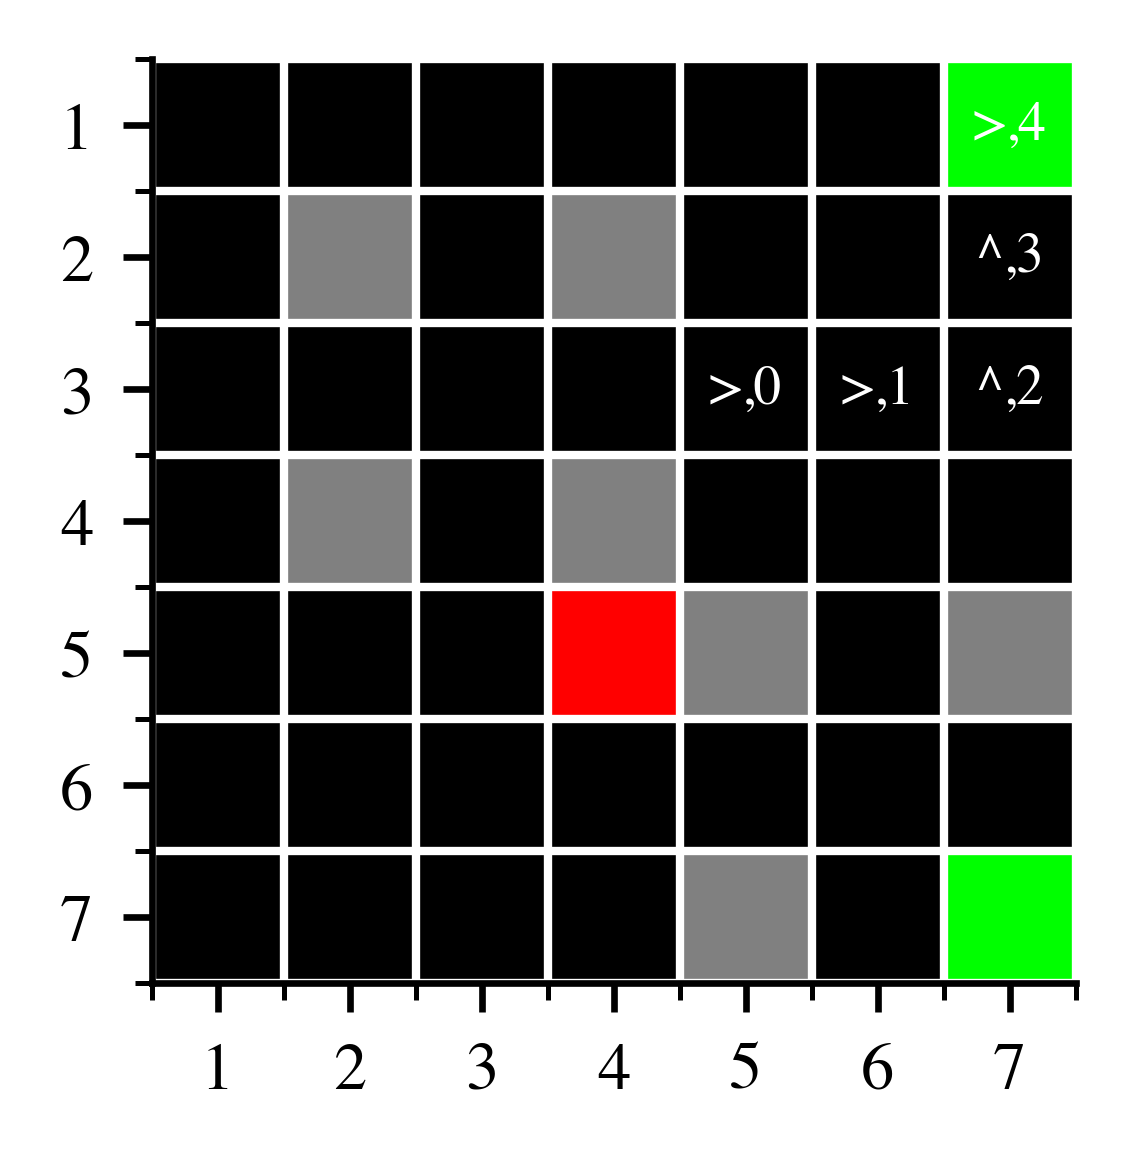

In [38]:
## finishing in top right corner
env.plot_traj(offline_data[clusters[1][0]])

In [39]:
## finishing in lava 
## means having a -1 reward in last but one state
# Set the seeds
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

final_clusters = []
for proposed_cluster in range(len(clusters)):
    finished_in_lava = 0

    for i in range(len(clusters[proposed_cluster])):
        
        if list(offline_data[clusters[proposed_cluster][i]])[-2][-2] == (-1.0):
            finished_in_lava+=1
    print("Cluster_id:", proposed_cluster)
    print("Percentage of trajectories finishing in lava {}%".format(finished_in_lava/len(clusters[proposed_cluster]) * 100))
    if finished_in_lava/len(clusters[proposed_cluster]) * 100 > 80 \
        and len(clusters[proposed_cluster]) > 2:
        print(f"Success, cluster {proposed_cluster} is the cluster which has the high-level behaviour of finishing in lava")
        final_clusters.append(proposed_cluster)

print("Final clusters finishing in lava are {}".format(final_clusters))

Cluster_id: 0
Percentage of trajectories finishing in lava 0.0%
Cluster_id: 1
Percentage of trajectories finishing in lava 0.0%
Cluster_id: 2
Percentage of trajectories finishing in lava 100.0%
Success, cluster 2 is the cluster which has the high-level behaviour of finishing in lava
Cluster_id: 3
Percentage of trajectories finishing in lava 100.0%
Cluster_id: 4
Percentage of trajectories finishing in lava 0.0%
Cluster_id: 5
Percentage of trajectories finishing in lava 50.0%
Cluster_id: 6
Percentage of trajectories finishing in lava 0.0%
Cluster_id: 7
Percentage of trajectories finishing in lava 0.0%
Cluster_id: 8
Percentage of trajectories finishing in lava 0.0%
Cluster_id: 9
Percentage of trajectories finishing in lava 0.0%
Final clusters finishing in lava are [2]


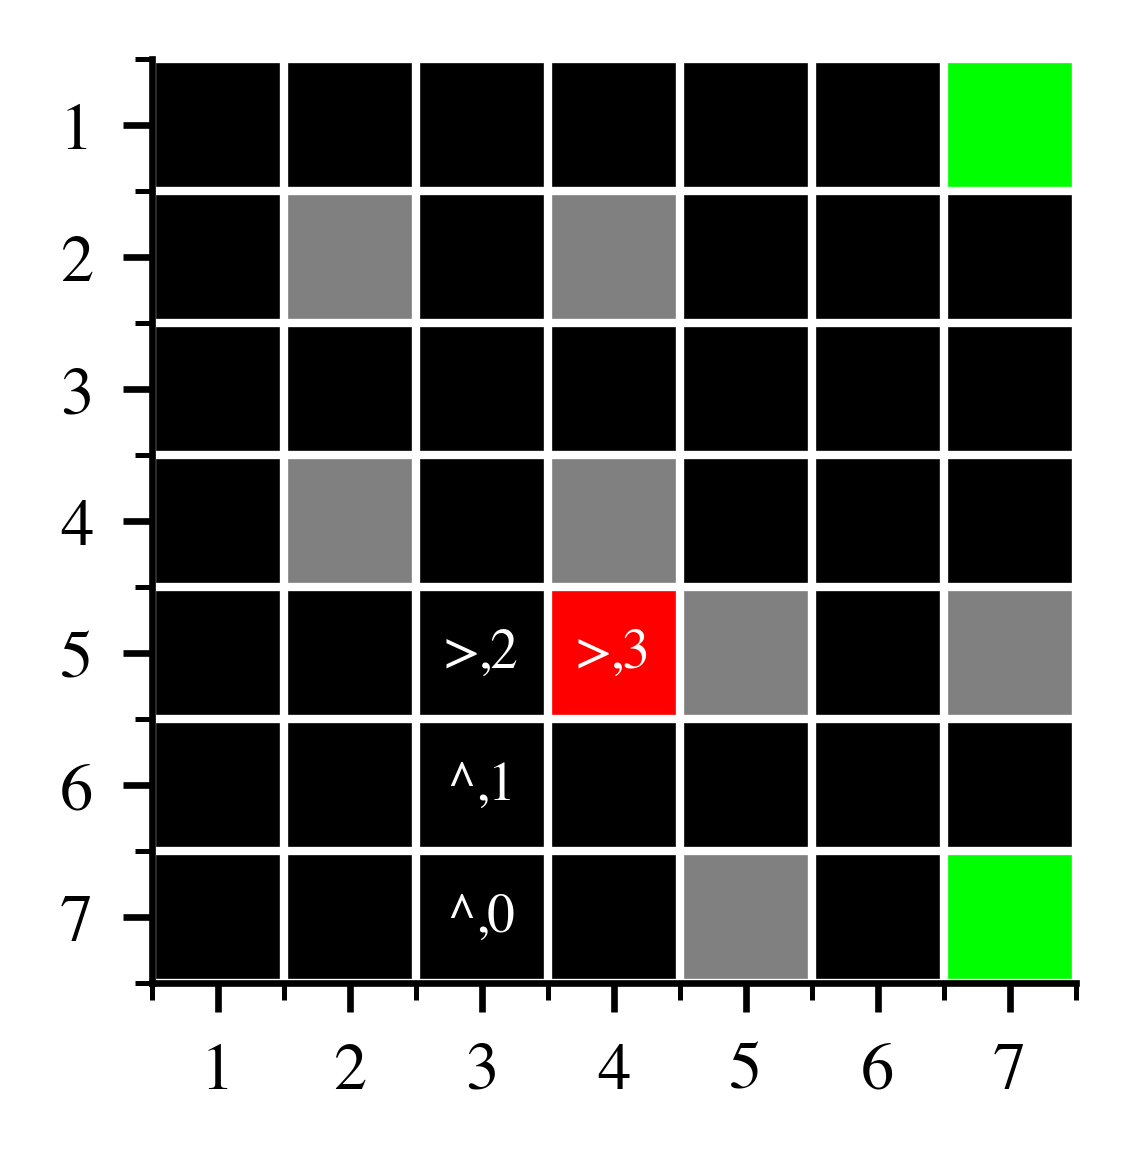

In [40]:
env.plot_traj(offline_data[clusters[2][0]])

In [41]:
## starting from mid-grid and finishing with goal
## means having a positive reward in the last but one state
## and having a starting point which is mid-grid
## How do we define mid-grid? Any starting point between position
## 7 and 35 in height and 
## thus:
# Set the seeds


final_clusters = []
for proposed_cluster in range(len(clusters)):
    started_mid_grid_finished_goal = 0

    for i in range(len(clusters[proposed_cluster])):
        if list(offline_data[clusters[proposed_cluster][i]])[0][0] in range(7, 40)  \
            and list(offline_data[clusters[proposed_cluster][i]])[-2][-2] == (1.0):
            started_mid_grid_finished_goal+=1 

    print("Cluster_id:", proposed_cluster)
    print("Percentage of trajectories starting in mid-grid and finishing in goal {}%".format(started_mid_grid_finished_goal/len(clusters[proposed_cluster]) * 100))
    if started_mid_grid_finished_goal/len(clusters[proposed_cluster]) * 100 > 80 \
        and len(clusters[proposed_cluster]) > 2: 
        print(f"Success, cluster {proposed_cluster} is the cluster which has the high-level behaviour of starting in mid-grid and finishing in goal")
        final_clusters.append(proposed_cluster)

print("Final clusters starting in mid-grid and finishing in goal are {}".format(final_clusters))

Cluster_id: 0
Percentage of trajectories starting in mid-grid and finishing in goal 100.0%
Success, cluster 0 is the cluster which has the high-level behaviour of starting in mid-grid and finishing in goal
Cluster_id: 1
Percentage of trajectories starting in mid-grid and finishing in goal 100.0%
Success, cluster 1 is the cluster which has the high-level behaviour of starting in mid-grid and finishing in goal
Cluster_id: 2
Percentage of trajectories starting in mid-grid and finishing in goal 0.0%
Cluster_id: 3
Percentage of trajectories starting in mid-grid and finishing in goal 0.0%
Cluster_id: 4
Percentage of trajectories starting in mid-grid and finishing in goal 77.77777777777779%
Cluster_id: 5
Percentage of trajectories starting in mid-grid and finishing in goal 50.0%
Cluster_id: 6
Percentage of trajectories starting in mid-grid and finishing in goal 87.5%
Success, cluster 6 is the cluster which has the high-level behaviour of starting in mid-grid and finishing in goal
Cluster_id: 

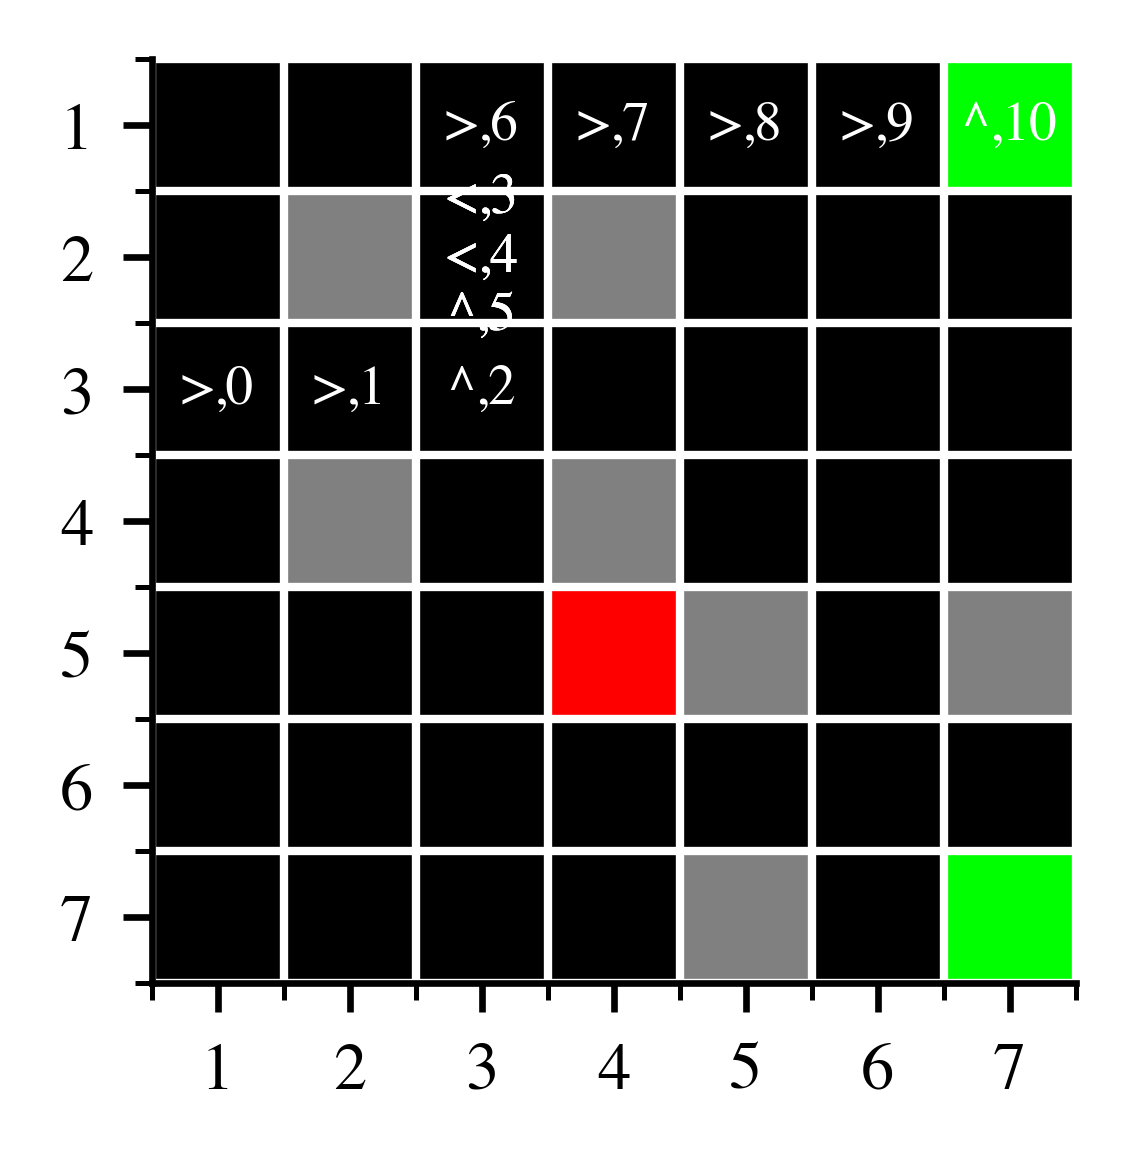

In [42]:
# mid-grid and finishing in goal
env.plot_traj(offline_data[clusters[6][5]])

In [43]:
counter = 0
for i in range(len(clusters)):
    for j in range(len(clusters[i])):
        # env.plot_traj(offline_data[clusters[0][j]])
        len_0 = len(offline_data[clusters[i][0]])
        if len(offline_data[clusters[i][j]]) != len_0:
            print("Cluster {} trajectory {} is not of lenght {}".format(i, j, len_0))
            counter += 1
    print("Cluster {} has all trajectories of length = {}".format(i, len_0))
if counter == 0:
    print("All trajectories belonging to the same clusters are of the same length")

Cluster 0 has all trajectories of length = 5
Cluster 1 has all trajectories of length = 5
Cluster 2 has all trajectories of length = 4
Cluster 3 has all trajectories of length = 4
Cluster 4 has all trajectories of length = 7
Cluster 5 has all trajectories of length = 6
Cluster 6 has all trajectories of length = 11
Cluster 7 has all trajectories of length = 10
Cluster 8 has all trajectories of length = 9
Cluster 9 has all trajectories of length = 8
All trajectories belonging to the same clusters are of the same length


## Metrics Section

The following section is about metrics used to compare different policies. 
1. Initial State Value Estimate 
    - Measure of expecteed long-term returns.
2. Local Mean Absolute Action-Value difference (Average delta q)
3. Action Contrast Measure



### Initial State Value Estimates

`result_data_combinations` is notghing but the dict comprising of all the complementary data embedding sets for each cluster and the new sets of actions from the new trained agent. 
It is a dict of key and a tuple made of (action_values_new, data_embedding_new) as value. 

In [44]:
# ivs_xmean = []
# for data_combination_id in result_data_combinations:
#     ## uncomment the following lines to get a better view if necesary
    
#     print(data_combination_id, result_data_combinations[data_combination_id][0].max(axis=1).mean())
#     ivs_xmean.append(result_data_combinations[data_combination_id][0].max(axis=1).mean())

ivs_xmean = []
for data_combination_id in result_data_combinations:
    ## uncomment the following lines to get a better view if necesary
    # print(data_combination_id)
    # print(result_data_combinations[data_combination_id][0])
    # print('max')
    # print(result_data_combinations[data_combination_id][0].max(axis=1))
    # print('data_combination_id', data_combination_id)
    # print(result_data_combinations[data_combination_id][0].max(axis=1).mean())
    
    ivs_xmean.append(result_data_combinations[data_combination_id][0].max(axis=1).mean())

ivs_xmean

[0.3054726522286102,
 0.30587083529978126,
 0.3056607541041124,
 0.3045628372612289,
 0.3045250520927269,
 0.3058591760688117,
 0.2980189232415628,
 0.2848451434534554,
 0.3058793360578949,
 0.3058755987636879,
 0.3046077730176018]

### Average delta q

As the average delta is a technique measuring how the original policy percieves suggestions given by explanation policies you are keeping `result_data_combinations[0][0]` because corresponding to `data_combination_id` == 0 is the original dataset and thus ` result_data_combinations[0][0]` corresponds to the original set of actions. 

In [45]:
deltaq_xmean = []
for data_combination_id, (action_values_new, data_embedding_new) in result_data_combinations.items():
    ## Expected value of the difference
    # print(np.sum(np.abs(action_values_new - result_data_combinations[0][0]))/(env_width*env_height))
    deltaq_xmean.append(np.sum(np.abs(action_values_new - result_data_combinations[0][0]))/(env_width*env_height))

deltaq_xmean

[0.0,
 0.002016201184693973,
 0.0006816132827011006,
 0.0018058865453707456,
 0.022341922545166693,
 0.0398596620914066,
 0.03195971110860135,
 0.07115474910669442,
 0.02817974037959011,
 0.0021131136027336206,
 0.02986533281903772]

### Compare the actions

In [46]:
action_comparison = {}
for data_combination_id, (action_values_new, data_embedding_new) in result_data_combinations.items(): 
    action_comparison[data_combination_id] = 0
    for i in range(env_width*env_height):
            orig_actions = np.where(result_data_combinations[0][0][i] == np.max(result_data_combinations[0][0][i]))[0]
            alternate_actions = np.where(result_data_combinations[data_combination_id][0][i] == np.max(result_data_combinations[data_combination_id][0][i]))[0]
            
            if list(orig_actions) == list(alternate_actions):
                action_comparison[data_combination_id] += 1 
#             alternate_actions = 
#     print(np.sum(np.argmax(action_values_new, axis=1) != np.argmax(result_data_combinations[0][0], axis=1))/(env_width*env_height))

In [47]:
action_comparison_xmean = np.array(list(action_comparison.values()))/(env_width*env_height)
action_comparison_xmean
# sum(action_comparison_xmean)/len(action_comparison_xmean)


array([1.        , 0.87755102, 0.87755102, 0.95918367, 0.95918367,
       0.87755102, 0.93877551, 0.87755102, 0.87755102, 0.87755102,
       0.95918367])

On top of this they compare distances between embeddings of original and complementary datasets using Wasserstein metric and cluster attribution frequency

### Data distances

In [48]:
data_distances = np.zeros(len(result_data_combinations))
for data_combination_id, (action_values_new, data_embedding_new) in result_data_combinations.items(): 
    data_distances[data_combination_id] = wasserstein_distance(data_embedding, data_embedding_new)

In [49]:
datadistances_xmean = []
with np.printoptions(precision=5, suppress=True):
    # print((data_distances - data_distances.min()) / (data_distances.max() - data_distances.min()))
    datadistances_xmean.append((data_distances - data_distances.min()) / (data_distances.max() - data_distances.min()))
    
datadistances_xmean

[array([0.00000000e+00, 1.05166030e-01, 4.67298109e-01, 1.00000000e+00,
        5.68865040e-02, 4.73799352e-02, 2.12887175e-02, 1.55249179e-04,
        1.66187132e-04, 1.00880581e-03, 3.34916842e-03])]

### Cluster Attribution Frequency

In [50]:
cluster_attr_freq = np.zeros(len(clusters))

In [51]:
for attribution in attributions:
    cluster_attr_freq[attribution['responsible_cluster']] += 1 

In [52]:
cluster_attr_freq_xmean = cluster_attr_freq/cluster_attr_freq.sum()
cluster_attr_freq_xmean

# sum(cluster_attr_freq_xmean)/len(cluster_attr_freq_xmean)

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.125, 0.5  , 0.375, 0.   ,
       0.   ])

# Using Clustering using DBSCAN to the End

In [53]:
# # ## load dataset if before you were using a different one, 60 trajectories
num_episodes_dyna = 2
num_agents_dyna = 5
max_traj_len = 10
num_pos_trajs = 50
num_neg_trajs = 10
results_save_dir = './gridworld_results/grid_7by7/'
# with open(os.path.join(results_save_dir, 'offline_traj60.pkl'), 'wb') as f:
#     pickle.dump(offline_data, f)

with open(os.path.join(results_save_dir, 'offline_traj60.pkl'), 'rb') as f:
    offline_data = pickle.load(f)

## Sequential Encoder DBSCAN (i)

We use sequential encoder to parse the offline data and create clusters of the trajectories which will be used for attributing the decisions in the later steps.

In [54]:
# Set the seeds
# random.seed(0)
# np.random.seed(0)
# torch.manual_seed(0)

def tokenizer(trajectories, state_space_dim, action_dict, reward_dict, max_traj_len = 25):
    """
        Tokenizer for capturing gridworld trajectories
    """

    action_space_dim = len(action_dict)
    reward_set_dim = len(reward_dict)
    
    # TOKEN IDs
    # 1 START TOKEN
    # 2 END TOKEN
    # 0 PAD TOKEN
    # STATE TOKENs
    # ACTION TOKENs
    # REWARD TOKENs
    
    complete_traj_tokens = []
    
    for traj in trajectories:
        # Traj contains (s,a,r,s')
        # We generate tokens for 's', 'a' and 'r'
        
        traj_tokens = []
        
        # Start token
        traj_tokens.append(1)
        
        for sars_ in traj:
            s = sars_[0]
            a = sars_[1]
            r = sars_[2]
            
            # State
            traj_tokens.append(3 + s)
            
            # Action
            traj_tokens.append(3 + state_space_dim + a)
            
            # Reward
            traj_tokens.append(3 + state_space_dim + action_space_dim + reward_dict[r])
        
        # Remove action and reward for terminal state, TO BE USED ONLY when (s_terminal, a_random, reward = 0, s_terminal) exists at the end of trajectory data
        traj_tokens.pop()
        traj_tokens.pop()
        
        # End token
        traj_tokens.append(2)
        
        # Pad with zero tokens
        if max_traj_len + 3 - len(traj) > 0:
            traj_tokens = traj_tokens + [0]*(3*(max_traj_len + 3 - len(traj)))
        
        complete_traj_tokens.append(torch.LongTensor(traj_tokens))
    
    return complete_traj_tokens

vocab_size = 3 + env_width*env_height + len(action_dict) + len(reward_dict)

tokenized_data = tokenizer(offline_data, 
                          state_space_dim = env_width*env_height, 
                          action_dict = action_dict, 
                          reward_dict = reward_dict, 
                          max_traj_len = max_traj_len)

In [55]:
class LSTMEncoder(nn.Module):
    def __init__(self, embedding_dim, vocab_size, hidden_size):
        super(LSTMEncoder, self).__init__()
        self.hidden_size = hidden_size
        self.token_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size)

    def forward(self, traj):
        embeds = self.token_embeddings(traj)
        o, (h_n, c_n) = self.lstm(embeds.view(len(traj), 1, -1)) # Batch first is false, -> Input shape (L(seq len), N(num seq), H_in(hidden size))
        # The LSTM output contains :
        # o - Outputs of individual cells : shape (L, N, H)
        # h_n - Final hidden state
        # c_n - Final cell state
        return o[-1], (h_n, c_n)
    
class LSTMDecoder(nn.Module):
    def __init__(self, embedding_size, hidden_size, vocab_size):
        super(LSTMDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                      embedding_dim=embedding_size,
                                      )

        self.lstm = nn.LSTM(embedding_size, hidden_size)
        self.out = nn.Linear(hidden_size, vocab_size)

    def forward(self, input, hidden_state, cell_state):
        # Input is START TOKEN
        # Hidden state, Cell state are taken from encoder's output

        # Get embedding
        embedded = self.embedding(input)        
        output = embedded.view(len(input), 1, -1)
        
        # Run LSTM to decode the trajectory
        output, _ = self.lstm(output, (hidden_state, cell_state))
        
        # Convert LSTM logits to vocab size softmax 
        out = self.out(output.squeeze(1))
        output = F.log_softmax(out, dim=1)
        
        return output

class Seq2Seq(nn.Module):
    
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, traj):
        traj_embedding = self.encoder(traj[1:])
        decoded_traj = self.decoder(traj[:-1], traj_embedding[1][0], traj_embedding[1][1])
        return decoded_traj, traj_embedding

traj_encoder = LSTMEncoder(embedding_dim=16, vocab_size= vocab_size, hidden_size=32)
traj_decoder = LSTMDecoder(embedding_size=16, hidden_size=32, vocab_size=vocab_size)

model = Seq2Seq(traj_encoder, traj_decoder)


### Training LSTM to encode trajectories in a seq2seq setting

In [56]:
# # Set the seeds
# random.seed(0)
# np.random.seed(0)
# torch.manual_seed(0)

# Hyperparameters 
num_epochs = 25

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=1)

In [57]:
# # Set the seeds
# random.seed(0)
# np.random.seed(0)
# torch.manual_seed(0)

model.train()

for epoch_id, epoch in enumerate(range(num_epochs)):
    total_loss = 0
    for traj_id, traj in enumerate(tokenized_data):
        optimizer.zero_grad()
        
        # Get decoded trajectory and its embedding
        decoded_traj, traj_embedding = model(traj)
        # Loss
        loss = F.nll_loss(decoded_traj.view(-1, vocab_size),
                          traj[1:].contiguous().view(-1),
                          ignore_index=0)
        
        # Optimize the model
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
        optimizer.step()
        
        # Record loss
        total_loss += loss.data.item()

    total_loss = total_loss / 100
    
    print(f'Epoch: {epoch_id + 1}, Loss:{total_loss}')

Epoch: 1, Loss:1.11340346544981


Epoch: 2, Loss:0.5122088016569615
Epoch: 3, Loss:0.3917909574881196
Epoch: 4, Loss:0.3165824056789279
Epoch: 5, Loss:0.2592676686123013
Epoch: 6, Loss:0.2183819454908371
Epoch: 7, Loss:0.19150890585035085
Epoch: 8, Loss:0.17201273366808892
Epoch: 9, Loss:0.1587253575026989
Epoch: 10, Loss:0.14653272299095987
Epoch: 11, Loss:0.13742611272260546
Epoch: 12, Loss:0.13037823842838406
Epoch: 13, Loss:0.1249823035672307
Epoch: 14, Loss:0.11977013442665338
Epoch: 15, Loss:0.11483585722744465
Epoch: 16, Loss:0.1119763720780611
Epoch: 17, Loss:0.1080980883911252
Epoch: 18, Loss:0.10567527451552451
Epoch: 19, Loss:0.10390043838880957
Epoch: 20, Loss:0.1015754290111363
Epoch: 21, Loss:0.10098108118399977
Epoch: 22, Loss:0.09863811549730599
Epoch: 23, Loss:0.09720131874084473
Epoch: 24, Loss:0.0958835768327117
Epoch: 25, Loss:0.09479318615980446


In [58]:
# torch.save(model.state_dict(), './ckpt_save_dir/seq2seq_traj_5.pth')
# torch.save(model.state_dict(), './ckpt_save_dir/seq2seq_traj_fourrooms.pth')
torch.save(model.state_dict(), './ckpt_save_dir/seq2seq_traj_7.pth')

In [59]:
# # Set the seeds
# random.seed(0)
# np.random.seed(0)
# torch.manual_seed(0)

# Load the trained model
traj_encoder = LSTMEncoder(embedding_dim=16, vocab_size= vocab_size, hidden_size=32)
traj_decoder = LSTMDecoder(embedding_size=16, hidden_size=32, vocab_size=vocab_size)

model = Seq2Seq(traj_encoder, traj_decoder)
# model.load_state_dict(torch.load('./ckpt_save_dir/seq2seq_traj_5.pth'))
# model.load_state_dict(torch.load('./ckpt_save_dir/seq2seq_traj_fourrooms.pth'))
model.load_state_dict(torch.load('./ckpt_save_dir/seq2seq_traj_7.pth'))

<All keys matched successfully>

### Encode trajectories in the offline dataset

In [60]:
# Load and generate trajectory embeddings
traj_embeddings = []

for traj_id, traj in enumerate(tokenized_data):
    with torch.no_grad():
        decoded_traj, traj_embedding = model(traj)
        # print(traj_embedding[1])
        traj_embeddings.append(torch.cat(traj_embedding[1], axis=-1).numpy().reshape(-1))

## traj_embeddings is a 60x64 dimensional vector. 
traj_embeddings[59].shape

(64,)

### PCA analysis of the trajectory embeddings

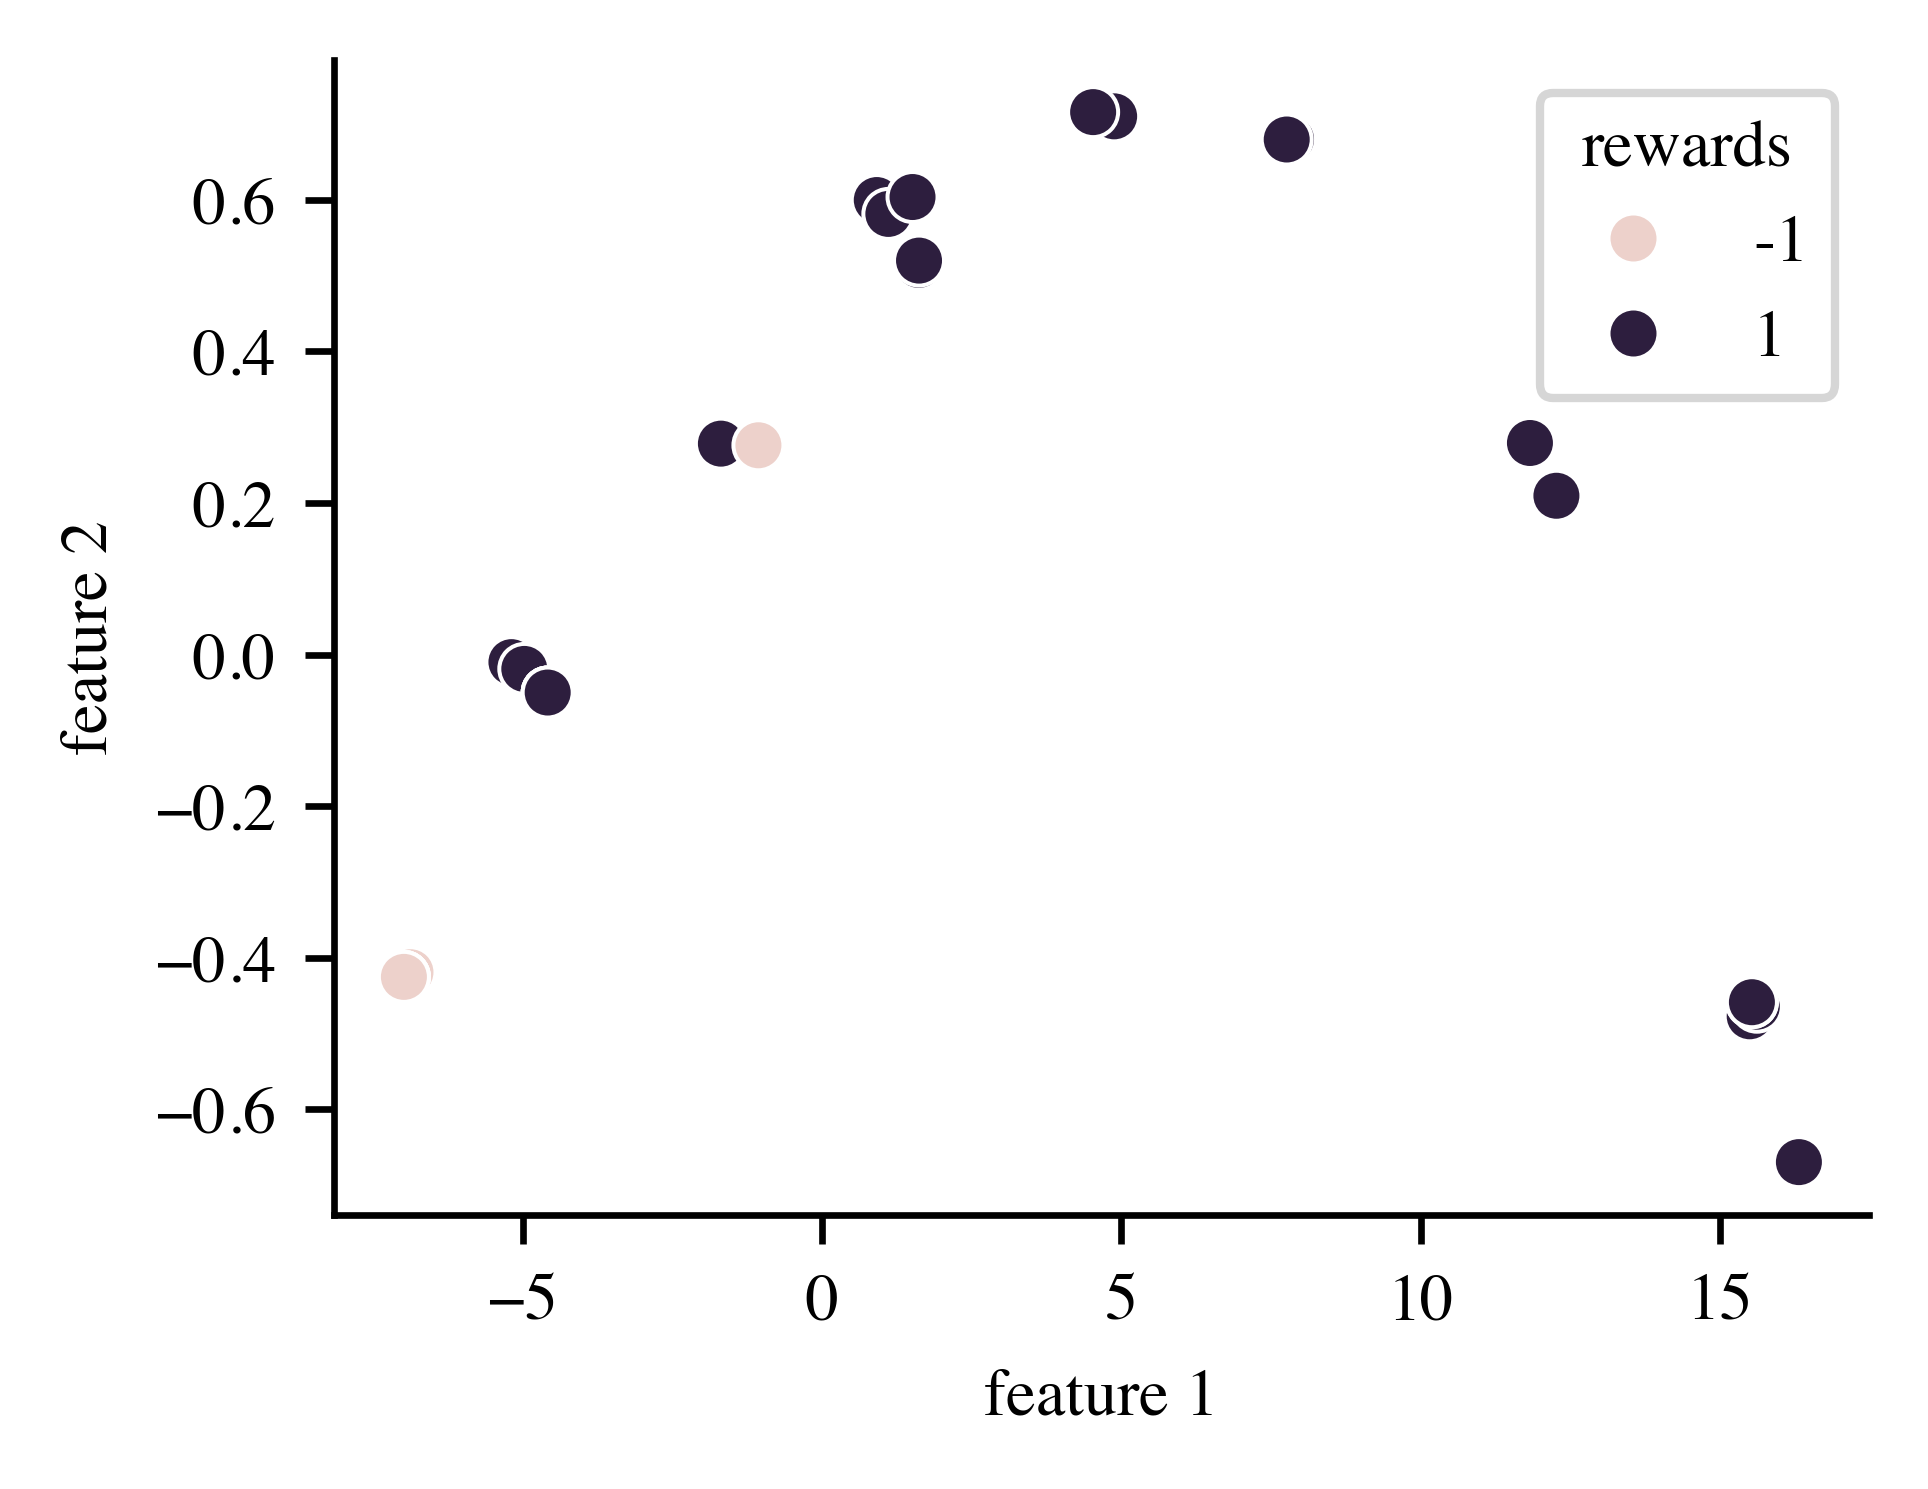

In [61]:
# Set the seeds
# random.seed(0)
# np.random.seed(0)
# torch.manual_seed(0)

pca = PCA(n_components=2)
pca_traj_embeddings = pca.fit_transform(traj_embeddings)
plotting_data = {'feature 1': pca_traj_embeddings[:, 0], 'feature 2': pca_traj_embeddings[:, 1],
                 'rewards': [+1] * num_pos_trajs + [-1] * num_neg_trajs}
df = pd.DataFrame(plotting_data)

plt.figure()
sns.scatterplot(x='feature 1', y='feature 2', hue='rewards', data=df)
# plt.title('PCA: Trajectory Embeddings')
# plt.legend()
plt.show()

# plt.figure()
# data_ax = sns.scatterplot(x='x',
#                           y='y',
#                           hue='labels',
#                           palette='deep',
#                           data=df,
#                           legend=True)
# for cid, _ in enumerate(cluster_data_embeds):
#     data_ax.text(pca_data_embeds[:, 0][cid],
#                  pca_data_embeds[:, 1][cid],
#                  str(cid),
#                  horizontalalignment='left',
#                  size='medium',
#                  color='black',
#                  weight='semibold')
# plt.title('PCA: Cluster Embeddings using ' + embed_gen_config['method_name'])
# plt.show()

In [62]:
# Prepare initial centers - amount of initial centers defines amount of clusters from which X-Means will
# start analysis.
from sklearn.cluster import DBSCAN

# amount_initial_centers = 2


dbscan = DBSCAN(eps=1.5, min_samples=2).fit(traj_embeddings)
clustering_labels = dbscan.labels_


clusters_dict = {}
for i, label in enumerate(clustering_labels):
    if label not in clusters_dict:
        clusters_dict[label] = [i]
    else:
        clusters_dict[label].append(i)

clusters = list(clusters_dict.values())

# Print total sum of metric errors
print("Clusters:", clusters)
print("Cluster Labels:", clustering_labels)
print('Number of clusters:', len(clusters))

Clusters: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25], [26, 50], [27, 28, 29, 30, 31, 32, 33, 34, 35], [36, 37], [38, 39], [40, 41], [42, 43, 44, 45, 46, 47, 48, 49], [51, 52, 53, 54, 55, 56, 57, 58, 59]]
Cluster Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 2 2 2 2 3
 3 4 4 5 5 6 6 6 6 6 6 6 6 1 7 7 7 7 7 7 7 7 7]
Number of clusters: 8


In [63]:
# for cluster_id, cluster in enumerate(clusters):
#     print('-'*10)
#     print('Cluster ID', cluster_id)
#     for traj_id in cluster:
#         env.plot_traj(offline_data[traj_id])    
#     print('-'*10)

Initializing cluster labels and assigning to every cluster a color

In [64]:
traj_cluster_labels = np.zeros(len(traj_embeddings), dtype=int)

for cluster_id, cluster in enumerate(clusters):
    for traj_id in cluster:
        traj_cluster_labels[traj_id] = cluster_id

traj_cluster_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6,
       6, 6, 6, 6, 6, 6, 1, 7, 7, 7, 7, 7, 7, 7, 7, 7])

In [65]:
palette = sns.color_palette('husl', len(clusters) + 1)
palette

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.8369430560927636, 0.5495828952802333, 0.1952683223448124),
 (0.6430915736746491, 0.6271955086583126, 0.19381135329796756),
 (0.3126890019504329, 0.6928754610296064, 0.1923704830330379),
 (0.20582072623426667, 0.6842209016721069, 0.5675558225732941),
 (0.2151139535594307, 0.6700707833028816, 0.7112365203426209),
 (0.23299120924703914, 0.639586552066035, 0.9260706093977744),
 (0.731751635642941, 0.5128186367840487, 0.9581005178234921),
 (0.9614880299080136, 0.3909885385134758, 0.8298287106954371)]

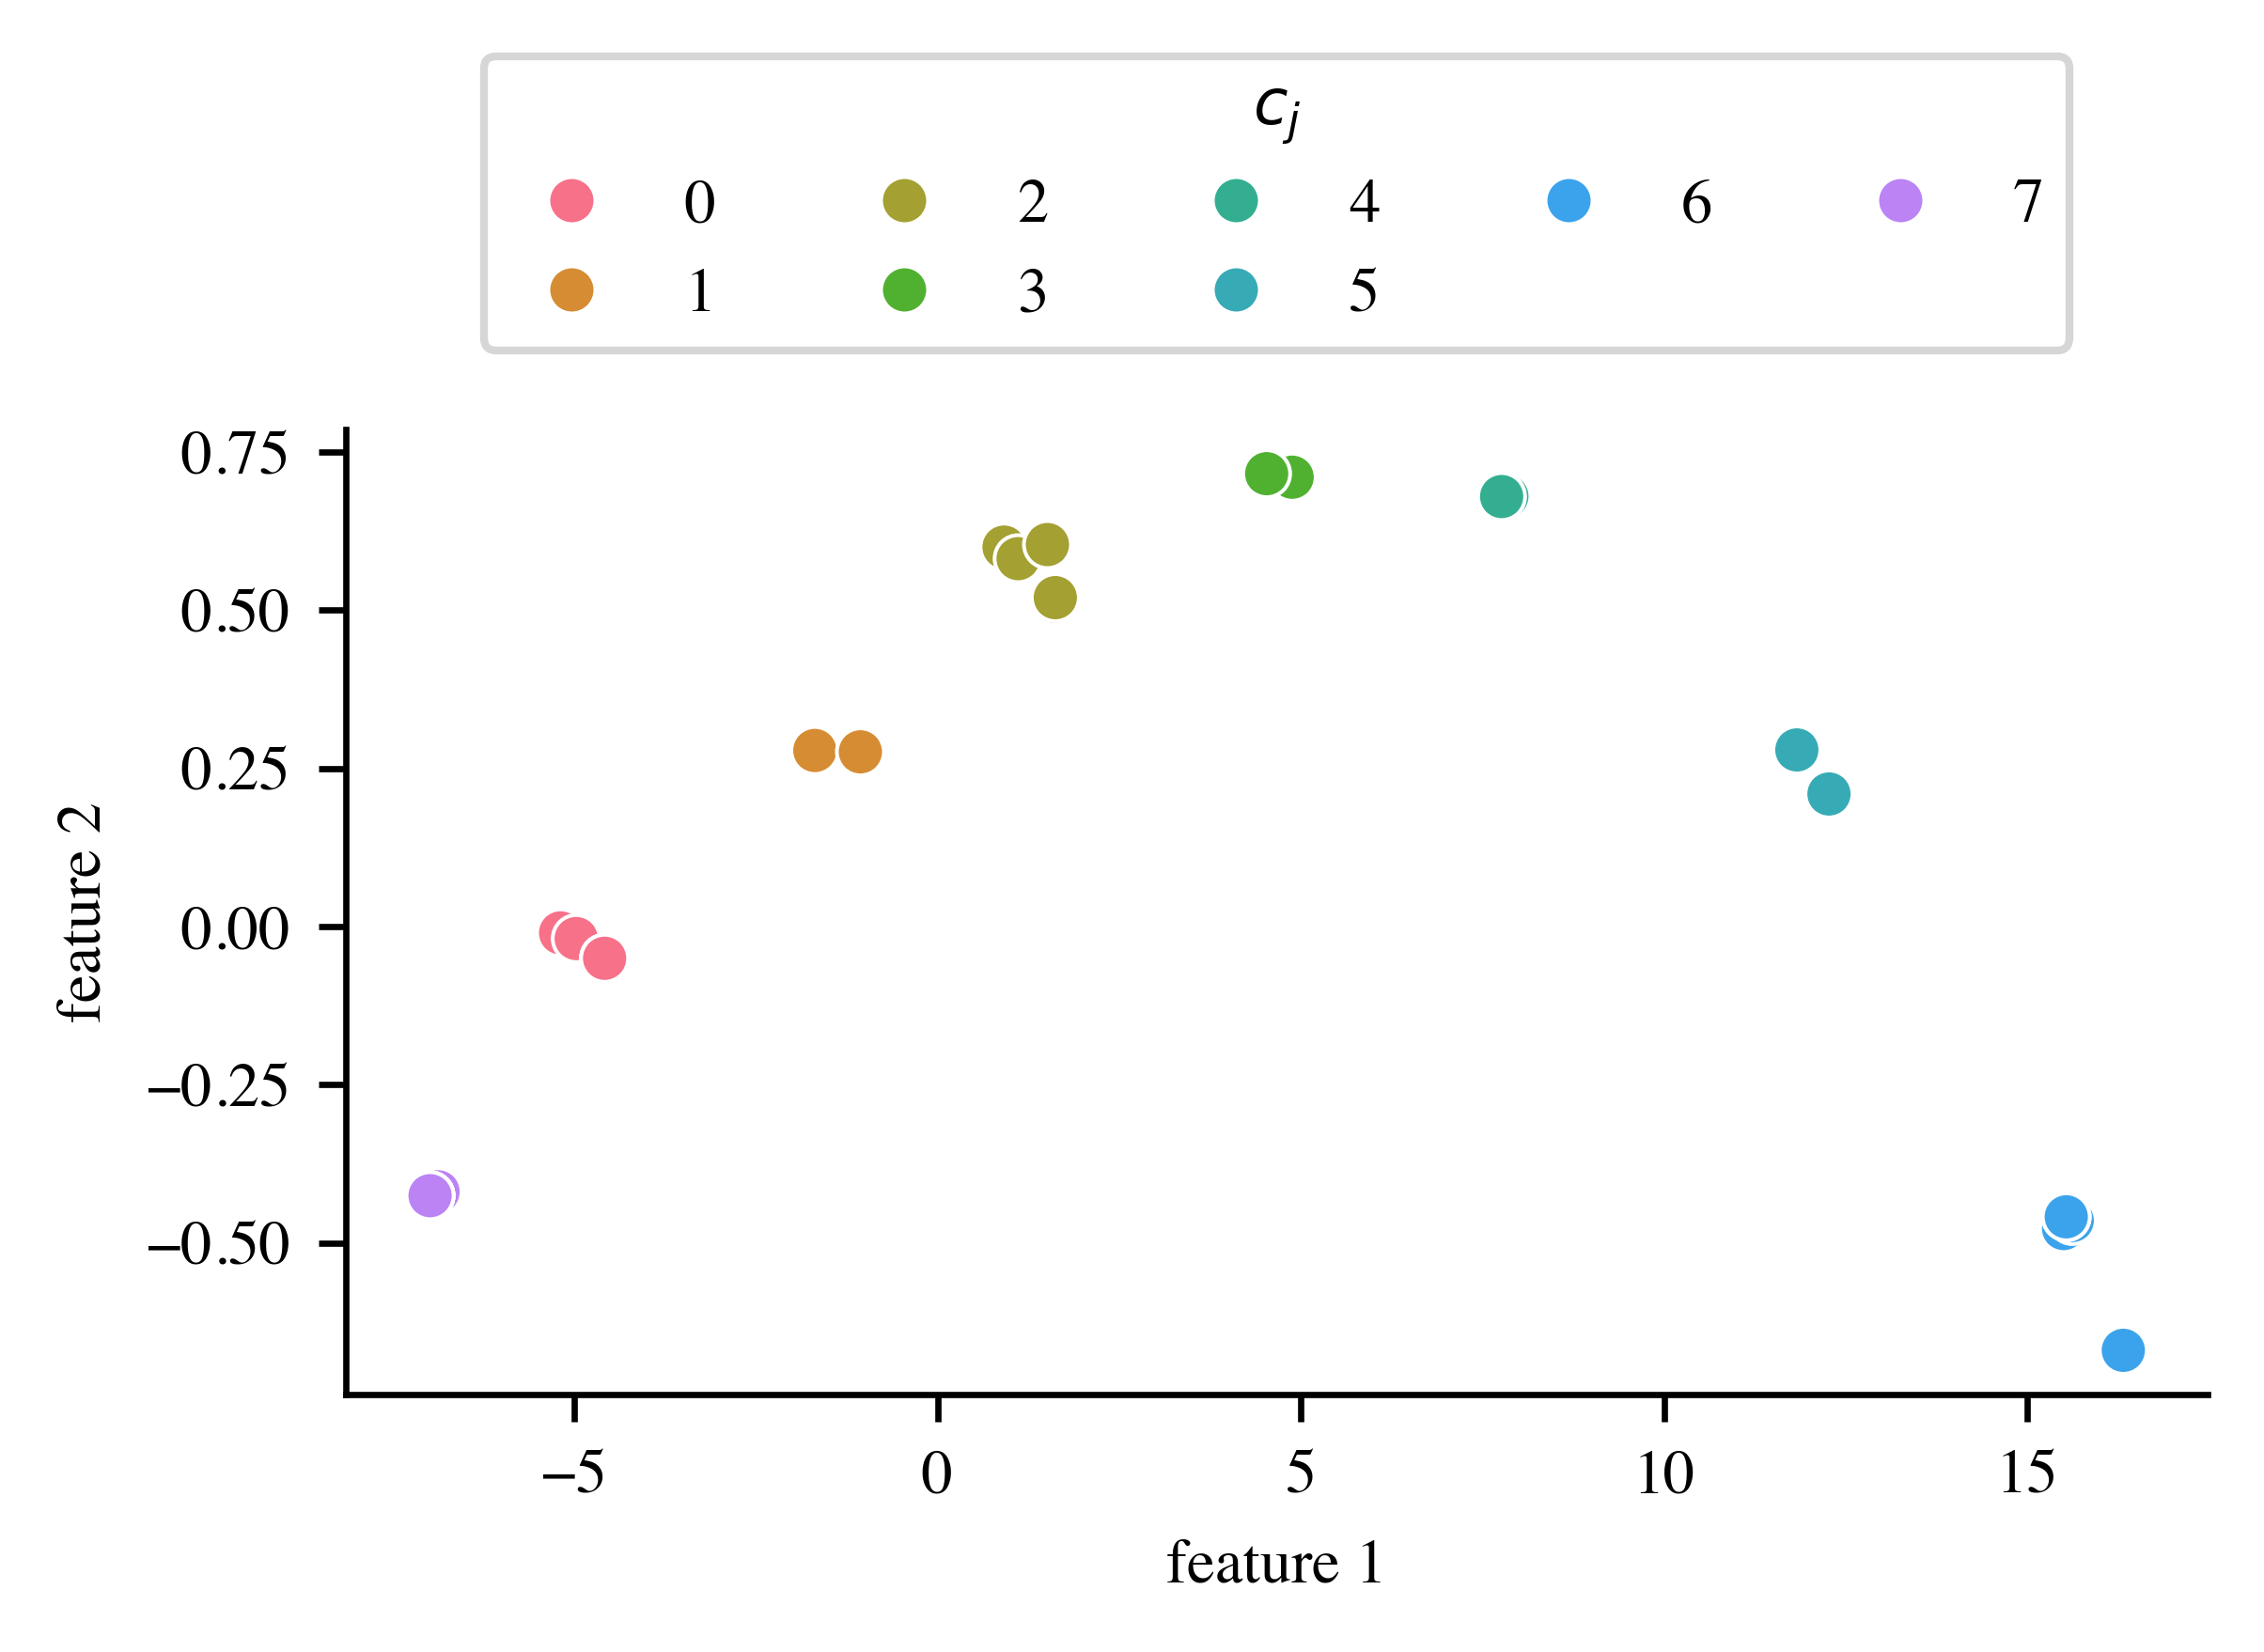

In [66]:
# cluster_data_embeds = [result_data_combinations[cid][1] for cid in result_data_combinations]
# cluster_data_embeds.pop(0)

pca_traj = PCA(n_components=2)
pca_traj_embeds = pca_traj.fit_transform(traj_embeddings)
plotting_data = {'feature 1': pca_traj_embeds[:, 0],
                 'feature 2': pca_traj_embeds[:, 1],
                 'cluster id': traj_cluster_labels}
df = pd.DataFrame(plotting_data)

plt.figure(figsize=(4,3))
data_ax = sns.scatterplot(x='feature 1',
                          y='feature 2',
                          hue='cluster id',
                          palette=palette[:len(clusters)],
                          data=df,
                          legend=True)
plt.legend(title = '$c_{j}$', loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=5)
# plt.legend(title = '$c_{j}$', loc='center left', bbox_to_anchor=(1., 0.7), ncol=2)
# for cid, _ in enumerate(cluster_data_embeds):
#     data_ax.text(pca_data_embeds[:, 0][cid],
#                  pca_data_embeds[:, 1][cid],
#                  str(cid),
#                  horizontalalignment='left',
#                  size='medium',
#                  color='black',
#                  weight='semibold')
plt.tight_layout()
plt.savefig('./traj_clustering_grid.pdf')
plt.show()

## Encode sets of trajectories

In [67]:
def get_data_embedding(traj_embeddings):
#     return np.exp(np.abs(np.array(traj_embeddings).sum(axis=0)/100.))/np.sum(np.abs(np.exp(np.array(traj_embeddings).sum(axis=0)/100.)))
    return np.exp(np.array(traj_embeddings).sum(axis=0)/10.)/np.sum(np.exp(np.array(traj_embeddings).sum(axis=0)/10.))

data_embedding = get_data_embedding(traj_embeddings)
data_embedding

array([1.1975065e-36, 1.0928535e-37, 3.0259351e-36, 2.4788125e-35,
       3.1020073e-35, 3.4121331e-37, 2.5878100e-36, 2.3928570e-38,
       1.9202033e-38, 7.7795130e-38, 1.0361071e-37, 5.8284812e-38,
       7.1727043e-37, 1.8824119e-36, 8.1016197e-39, 2.1322800e-35,
       1.7671605e-35, 1.3242250e-36, 1.5023165e-38, 3.3046082e-35,
       3.9567562e-35, 9.9651648e-38, 2.9507402e-38, 5.4853615e-38,
       6.1521877e-37, 2.0026519e-37, 3.7528185e-38, 6.5094540e-38,
       3.1796385e-35, 7.6678923e-36, 9.0614590e-38, 6.9486481e-39,
       2.5595080e-36, 1.0120980e-38, 2.5185055e-04, 9.9974811e-01,
       3.5082408e-34, 2.0563663e-37, 1.1614618e-35, 1.1450738e-39,
       6.8191527e-40, 1.8677725e-39, 0.0000000e+00, 1.4220587e-39,
       6.7864530e-37, 8.1876037e-36, 1.4012985e-44, 9.0653103e-35,
       2.6496561e-34, 5.0928038e-36, 0.0000000e+00, 5.1675514e-22,
       6.3248520e-29, 2.2749506e-39, 3.6994279e-43, 1.5856939e-39,
       5.4861597e-37, 2.9796333e-38, 1.4369195e-39, 0.0000000e

### Train models on different cluster combinations

In [68]:
transition_model, reward_model = generate_model(env, offline_data)
values, action_values, policy = dp(env, transition_model, reward_model, gamma=0.95, threshold=1e-4)

In [69]:
result_data_combinations = {0:(action_values, data_embedding)}
cluster_embeddings = {}

for cluster_id, cluster in enumerate(clusters):
    
    temp_data = []
    temp_traj_embeds = []
    temp_cluster_traj_embeds = []
    for traj_id, traj in enumerate(offline_data):
        if traj_id not in cluster:
            temp_data.append(offline_data[traj_id])
            temp_traj_embeds.append(traj_embeddings[traj_id])
        else:
            temp_cluster_traj_embeds.append(traj_embeddings[traj_id])
            
    # Generate the data embedding
    data_embedding_new = get_data_embedding(temp_traj_embeds)
    
    # Generate cluster embedding
    cluster_embedding = get_data_embedding(temp_cluster_traj_embeds)
    
    # Train an agent on the new data
    transition_model_new, reward_model_new = generate_model(env, temp_data)
    values_new, action_values_new, policy_new = dp(env,
                                                   transition_model_new,
                                                   reward_model_new,
                                                   gamma=0.95,
                                                   threshold=1e-4)
    
    # Collect the data embedding and the trajectory
    result_data_combinations[cluster_id + 1] = (action_values_new, data_embedding_new)
    cluster_embeddings[cluster_id] = cluster_embedding

### Generate attributions

In [70]:
attributions = []

for state in range(np.prod(env.dim)):
    
    if (state//env_width, state%env_width) in env.terminals:
        continue
        
    orig_state_action_values = action_values[state]
    orig_opt_state_actions = np.where(orig_state_action_values == np.max(orig_state_action_values))[0]

    distances = []
    new_actions = []
    for data_combination_id, (action_values_new, data_embedding_new) in result_data_combinations.items():
        new_state_action_values = action_values_new[state]
        new_opt_state_actions = np.where(new_state_action_values == np.max(new_state_action_values))[0]

        if list(new_opt_state_actions) != list(orig_opt_state_actions):
            w_d = wasserstein_distance(data_embedding, data_embedding_new)
        else:
            w_d = 1e9
        
        distances.append(w_d)
        new_actions.append(new_opt_state_actions)

    ## argsorting on the distances and selecting the zero-th element. This corresponds to the smallest distance cluster for that state for every complementary data embedding set.
    responsible_data_combination = np.argsort(distances)[0]

    ## if you want print these two, so that you can see the distances and the smallest distance cluster. 
    # print(distances, distances[responsible_data_combination], responsible_data_combination)
    ## if you print this, you understand how trajectories are grouped and why `Responsible trajectory id` is showing what it is showing.
    # print(clusters)


    if distances[responsible_data_combination] == 1e9 or distances[responsible_data_combination] == 0:
        continue
    
    print('-'*10)
    print(f'State - {state%env_width + 1, state//env_width + 1}')
    print(f'Distance - {distances[responsible_data_combination]}')
    print(f'Original Actions -{[action_dict[orig_action] for orig_action in orig_opt_state_actions]}')
    print(f'New Action - {[action_dict[new_action] for new_action in new_actions[responsible_data_combination]]}')

    print(f'Responsible data combination - data id {responsible_data_combination}')
    print(f'Responsible trajectory id {clusters[responsible_data_combination - 1]}')
    if len(clusters[responsible_data_combination - 1]):
        cid_list = list(range(len(clusters)))
        cid_list.pop(responsible_data_combination - 1)
        alternate_cid = np.random.choice(cid_list)
        attributions.append({
            'state' : (state%env_width + 1, state//env_width + 1),
            'orig_act': [action_dict[orig_action] for orig_action in orig_opt_state_actions],
            'new_act': [action_dict[new_action] for new_action in new_actions[responsible_data_combination]],
            'attributed_trajs':clusters[responsible_data_combination - 1],
            'random_baseline_trajs': list(np.random.randint(0, len(offline_data), 5)),
            'alternate_cluster_trajs': clusters[alternate_cid - 1],
            'responsible_cluster': responsible_data_combination - 1
        })
#         for traj in clusters[responsible_data_combination - 1]:
#             env.plot_traj(offline_data[traj])
    print('-'*10)

----------
State - (1, 1)
Distance - 5.443173336061591e-06
Original Actions -['RIGHT']
New Action - ['LEFT', 'UP', 'RIGHT', 'DOWN']
Responsible data combination - data id 7
Responsible trajectory id [42, 43, 44, 45, 46, 47, 48, 49]
----------
----------
State - (2, 1)
Distance - 5.443173336061591e-06
Original Actions -['RIGHT']
New Action - ['LEFT', 'UP', 'RIGHT', 'DOWN']
Responsible data combination - data id 7
Responsible trajectory id [42, 43, 44, 45, 46, 47, 48, 49]
----------
----------
State - (1, 2)
Distance - 5.443173336061591e-06
Original Actions -['UP']
New Action - ['LEFT', 'UP', 'RIGHT', 'DOWN']
Responsible data combination - data id 7
Responsible trajectory id [42, 43, 44, 45, 46, 47, 48, 49]
----------
----------
State - (5, 2)
Distance - 1.0834839940798702e-06
Original Actions -['UP']
New Action - ['RIGHT']
Responsible data combination - data id 5
Responsible trajectory id [38, 39]
----------
----------
State - (1, 3)
Distance - 1.0834839940798702e-06
Original Actions -[

In [71]:
attributions

[{'state': (1, 1),
  'orig_act': ['RIGHT'],
  'new_act': ['LEFT', 'UP', 'RIGHT', 'DOWN'],
  'attributed_trajs': [42, 43, 44, 45, 46, 47, 48, 49],
  'random_baseline_trajs': [9, 44, 15, 38, 14],
  'alternate_cluster_trajs': [0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25],
  'responsible_cluster': 6},
 {'state': (2, 1),
  'orig_act': ['RIGHT'],
  'new_act': ['LEFT', 'UP', 'RIGHT', 'DOWN'],
  'attributed_trajs': [42, 43, 44, 45, 46, 47, 48, 49],
  'random_baseline_trajs': [4, 16, 36, 7, 23],
  'alternate_cluster_trajs': [0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25],
  'responsible_cluster': 6},
 {'state': (1, 2),
  'orig_act': ['UP'],
  'new_act': ['LEFT', 'UP', 'RIGHT', 'DOWN'],
  'attributed_trajs': [42, 43, 44, 45, 46, 47, 48, 49],
  'random_ba

In [72]:
results_save_dir = './gridworld_results/grid_7by7/'
if not os.path.exists(results_save_dir):
    os.makedirs(results_save_dir)


# for traj_id, traj in enumerate(offline_data):
#     env.plot_traj(traj, path=os.path.join(results_save_dir, 'traj_' + str(traj_id) + '.png'))


In [73]:
class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

In [74]:
# Data to save
data_to_be_saved = [
    {
        'attributions' : attributions,
    }
]

dumped = json.dumps(data_to_be_saved, cls=NumpyEncoder)

with open(os.path.join(results_save_dir, 'attribution_results.json'), 'w') as f:
    json.dump(dumped, f)

## Analyzing High-Level Cluster Behaviours


In [75]:
## finishing in top right corner 
## means having a positive reward in the last but one state 
## and going towards position 6
# Set the seeds
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

final_clusters = []
for proposed_cluster in range(len(clusters)):
    finished_in_top_right = 0

    for i in range(len(clusters[proposed_cluster])):
        if list(offline_data[clusters[proposed_cluster][i]])[-2][-2:] == (1.0, 6):
            finished_in_top_right+=1
            
    print("Cluster_id:", proposed_cluster)
    print("Percentage of trajectories finishing in top right {}%".format(finished_in_top_right/len(clusters[proposed_cluster]) * 100))
        
    if finished_in_top_right/len(clusters[proposed_cluster]) * 100 > 80 \
        and len(clusters[proposed_cluster]) > 2: 

        print(f"Success, cluster {proposed_cluster} is the cluster which has the high-level behaviour of finishing in top right")
        final_clusters.append(proposed_cluster)

print("Final clusters finishing in top right are {}".format(final_clusters))

Cluster_id: 0
Percentage of trajectories finishing in top right 100.0%
Success, cluster 0 is the cluster which has the high-level behaviour of finishing in top right
Cluster_id: 1
Percentage of trajectories finishing in top right 50.0%
Cluster_id: 2
Percentage of trajectories finishing in top right 77.77777777777779%
Cluster_id: 3
Percentage of trajectories finishing in top right 50.0%
Cluster_id: 4
Percentage of trajectories finishing in top right 100.0%
Cluster_id: 5
Percentage of trajectories finishing in top right 50.0%
Cluster_id: 6
Percentage of trajectories finishing in top right 87.5%
Success, cluster 6 is the cluster which has the high-level behaviour of finishing in top right
Cluster_id: 7
Percentage of trajectories finishing in top right 0.0%
Final clusters finishing in top right are [0, 6]


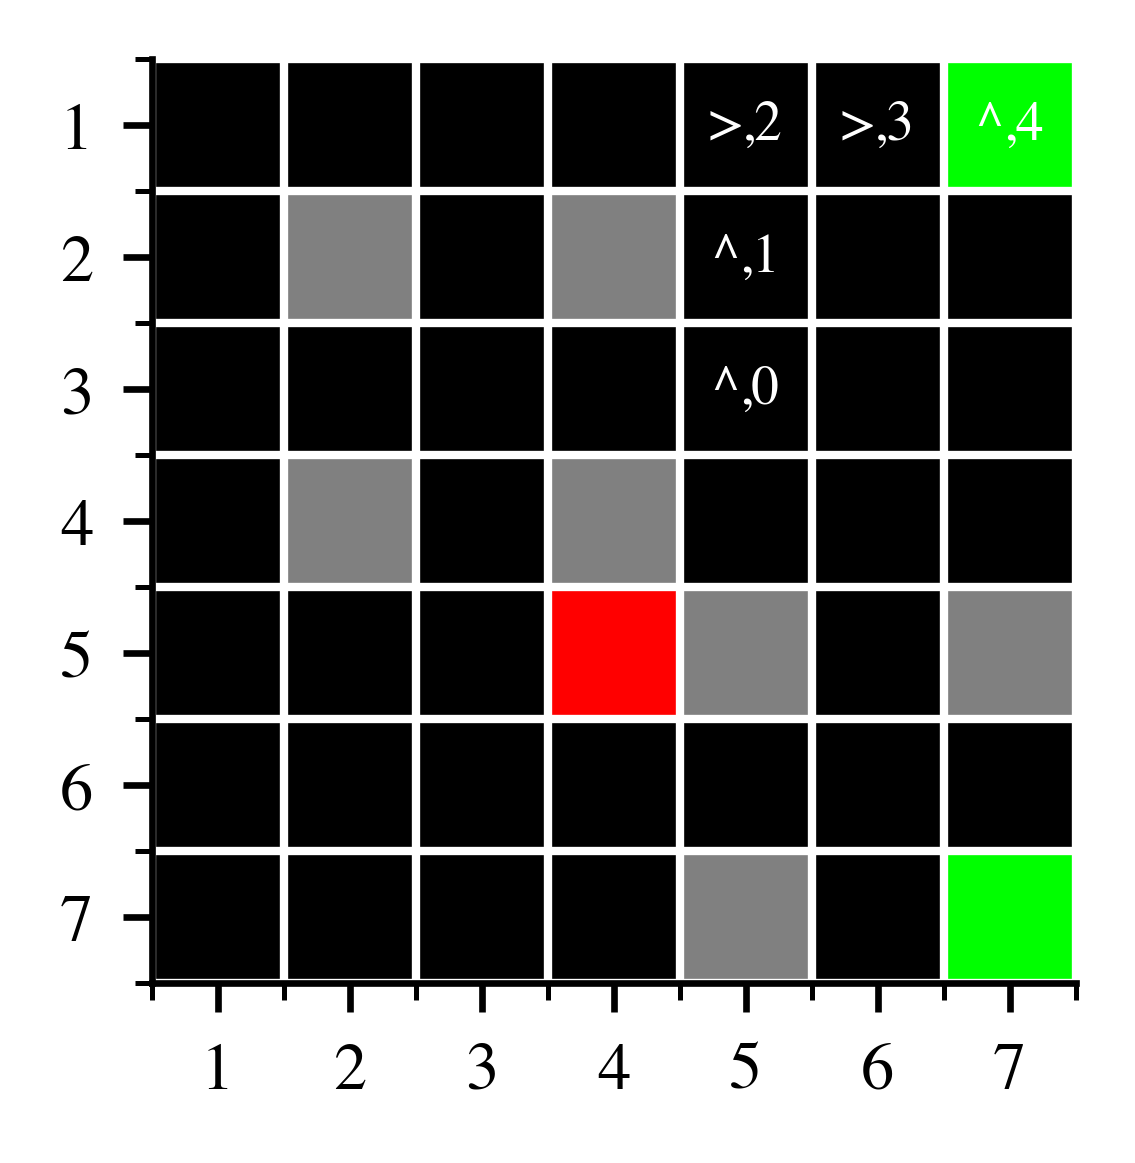

In [76]:
## finishing in top right corner
env.plot_traj(offline_data[clusters[final_clusters[0]][0]])

In [77]:
## finishing in lava 
## means having a -1 reward in last but one state
# Set the seeds
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

final_clusters = []
for proposed_cluster in range(len(clusters)):
    finished_in_lava = 0

    for i in range(len(clusters[proposed_cluster])):
        
        if list(offline_data[clusters[proposed_cluster][i]])[-2][-2] == (-1.0):
            finished_in_lava+=1
    print("Cluster_id:", proposed_cluster)
    print("Percentage of trajectories finishing in lava {}%".format(finished_in_lava/len(clusters[proposed_cluster]) * 100))
    if finished_in_lava/len(clusters[proposed_cluster]) * 100 > 80 \
        and len(clusters[proposed_cluster]) > 2:
        print(f"Success, cluster {proposed_cluster} is the cluster which has the high-level behaviour of finishing in lava")
        final_clusters.append(proposed_cluster)

print("Final clusters finishing in lava are {}".format(final_clusters))

Cluster_id: 0
Percentage of trajectories finishing in lava 0.0%
Cluster_id: 1
Percentage of trajectories finishing in lava 50.0%
Cluster_id: 2
Percentage of trajectories finishing in lava 0.0%
Cluster_id: 3
Percentage of trajectories finishing in lava 0.0%
Cluster_id: 4
Percentage of trajectories finishing in lava 0.0%
Cluster_id: 5
Percentage of trajectories finishing in lava 0.0%
Cluster_id: 6
Percentage of trajectories finishing in lava 0.0%
Cluster_id: 7
Percentage of trajectories finishing in lava 100.0%
Success, cluster 7 is the cluster which has the high-level behaviour of finishing in lava
Final clusters finishing in lava are [7]


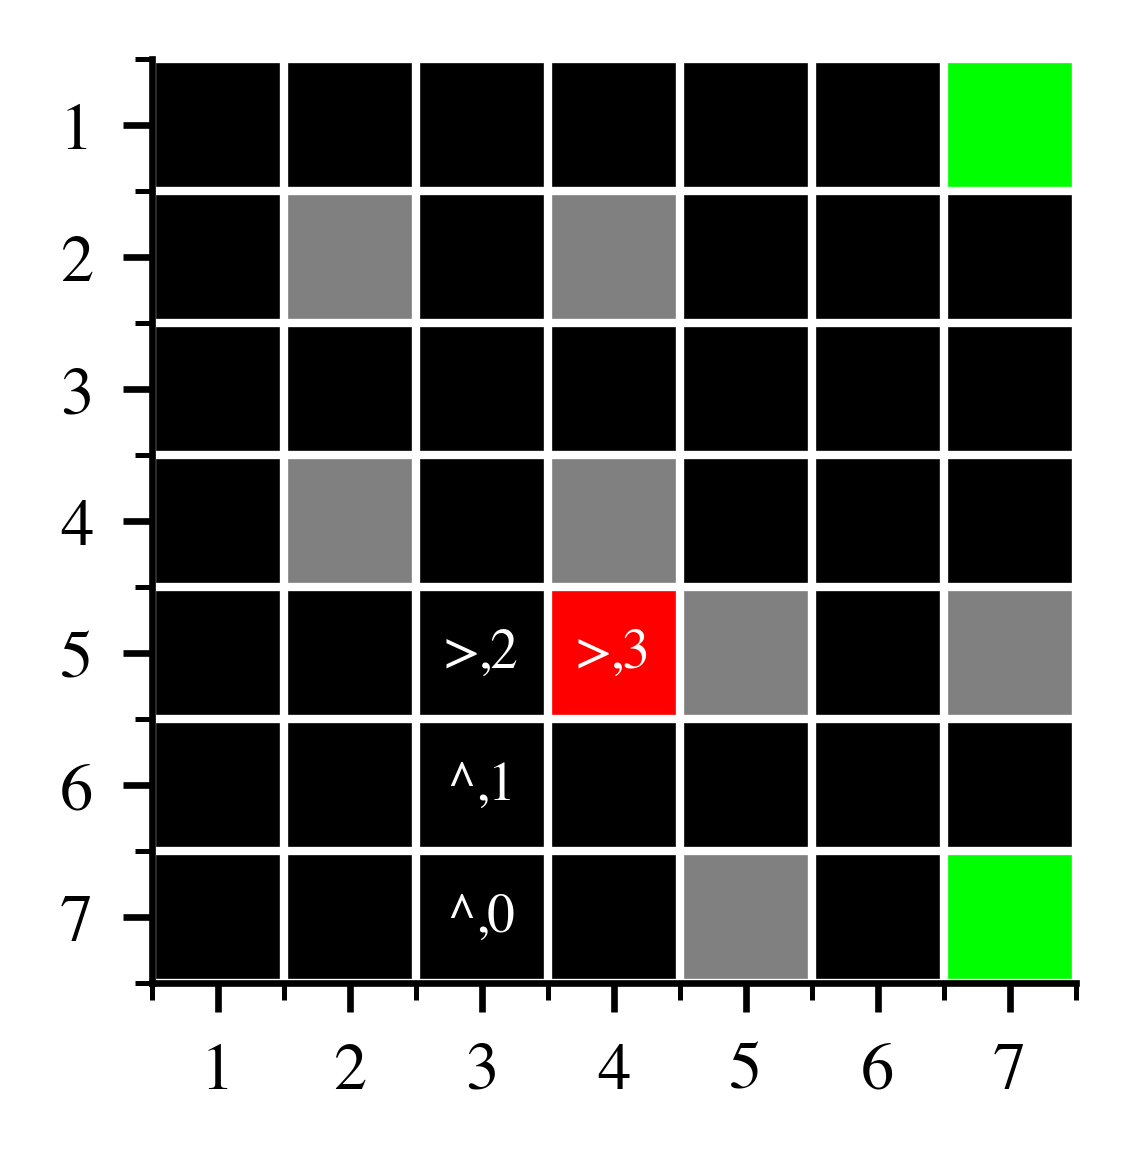

In [78]:
env.plot_traj(offline_data[clusters[final_clusters[0]][0]])

In [79]:
## starting from mid-grid and finishing with goal
## means having a positive reward in the last but one state
## and having a starting point which is mid-grid
## How do we define mid-grid? Any starting point between position
## 7 and 35 in height and 
## thus:
# Set the seeds


final_clusters = []
for proposed_cluster in range(len(clusters)):
    started_mid_grid_finished_goal = 0

    for i in range(len(clusters[proposed_cluster])):
        if list(offline_data[clusters[proposed_cluster][i]])[0][0] in range(7, 40)  \
            and list(offline_data[clusters[proposed_cluster][i]])[-2][-2] == (1.0):
            started_mid_grid_finished_goal+=1 

    print("Cluster_id:", proposed_cluster)
    print("Percentage of trajectories starting in mid-grid and finishing in goal {}%".format(started_mid_grid_finished_goal/len(clusters[proposed_cluster]) * 100))
    if started_mid_grid_finished_goal/len(clusters[proposed_cluster]) * 100 > 80 \
        and len(clusters[proposed_cluster]) > 2: 
        print(f"Success, cluster {proposed_cluster} is the cluster which has the high-level behaviour of starting in mid-grid and finishing in goal")
        final_clusters.append(proposed_cluster)

print("Final clusters starting in mid-grid and finishing in goal are {}".format(final_clusters))

Cluster_id: 0
Percentage of trajectories starting in mid-grid and finishing in goal 100.0%
Success, cluster 0 is the cluster which has the high-level behaviour of starting in mid-grid and finishing in goal
Cluster_id: 1
Percentage of trajectories starting in mid-grid and finishing in goal 50.0%
Cluster_id: 2
Percentage of trajectories starting in mid-grid and finishing in goal 77.77777777777779%
Cluster_id: 3
Percentage of trajectories starting in mid-grid and finishing in goal 50.0%
Cluster_id: 4
Percentage of trajectories starting in mid-grid and finishing in goal 100.0%
Cluster_id: 5
Percentage of trajectories starting in mid-grid and finishing in goal 50.0%
Cluster_id: 6
Percentage of trajectories starting in mid-grid and finishing in goal 87.5%
Success, cluster 6 is the cluster which has the high-level behaviour of starting in mid-grid and finishing in goal
Cluster_id: 7
Percentage of trajectories starting in mid-grid and finishing in goal 0.0%
Final clusters starting in mid-grid 

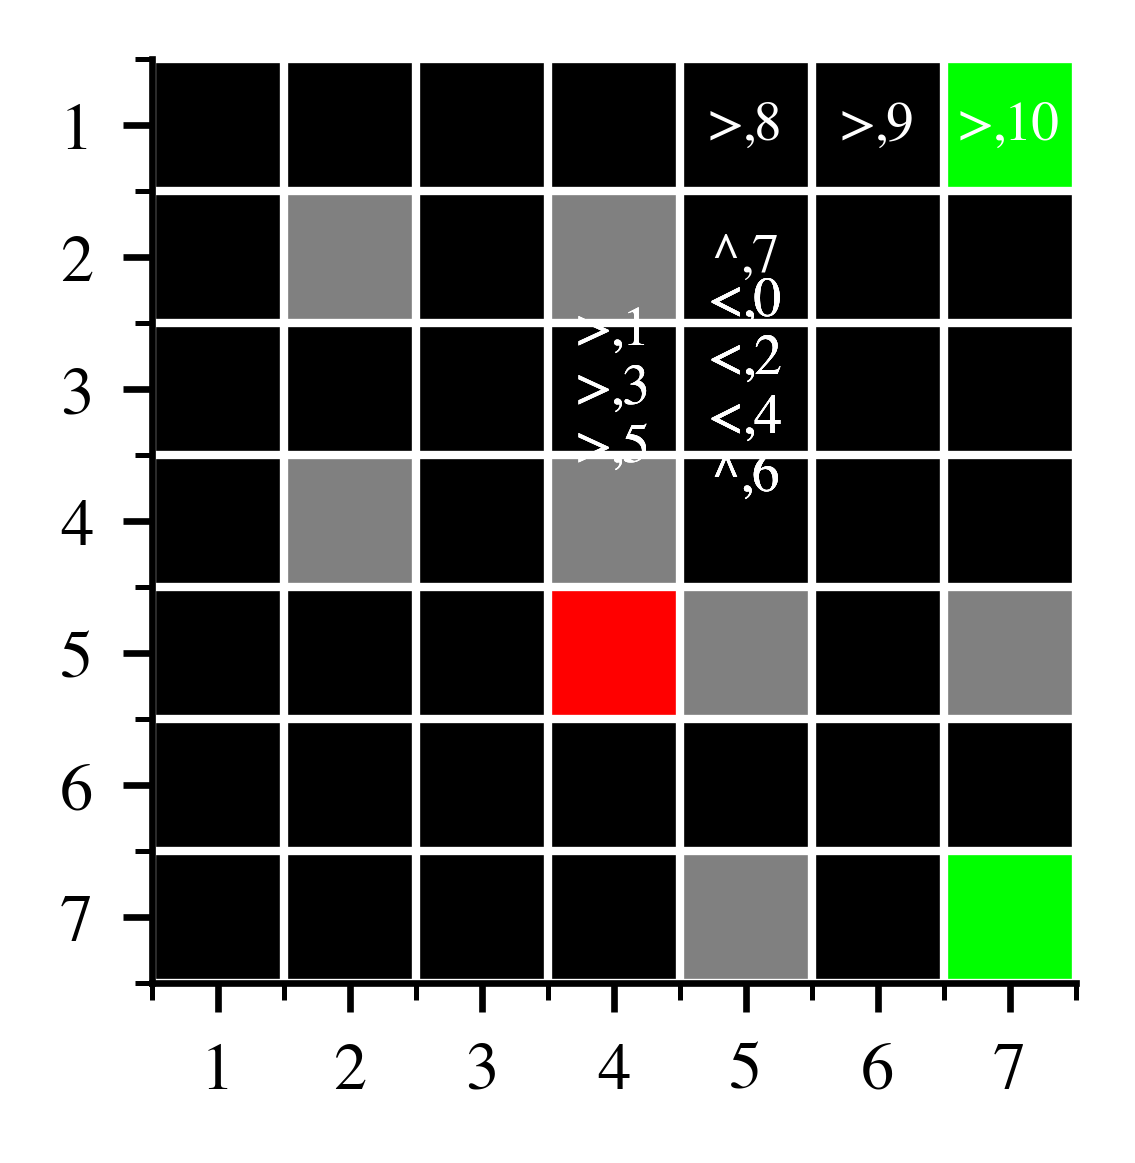

In [80]:
# mid-grid and finishing in goal
env.plot_traj(offline_data[clusters[final_clusters[1]][0]])

In [81]:
counter = 0
for i in range(len(clusters)):
    for j in range(len(clusters[i])):
        # env.plot_traj(offline_data[clusters[0][j]])
        len_0 = len(offline_data[clusters[i][0]])
        if len(offline_data[clusters[i][j]]) != len_0:
            print("Cluster {} trajectory {} is not of lenght {}".format(i, j, len_0))
            counter += 1
    print("Cluster {} has all trajectories of length = {}".format(i, len_0))
if counter == 0:
    print("All trajectories belonging to the same clusters are of the same length")

Cluster 0 has all trajectories of length = 5
Cluster 1 has all trajectories of length = 6
Cluster 2 has all trajectories of length = 7
Cluster 3 has all trajectories of length = 8
Cluster 4 has all trajectories of length = 9
Cluster 5 has all trajectories of length = 10
Cluster 6 has all trajectories of length = 11
Cluster 7 has all trajectories of length = 4
All trajectories belonging to the same clusters are of the same length


## Metrics Section

### Initial State Value Estimates

In [82]:
ivs_dbscan = []
for data_combination_id in result_data_combinations:
    ## uncomment the following lines to get a better view if necesary
    # print(data_combination_id)
    # print(result_data_combinations[data_combination_id][0])
    # print('max')
    # print(result_data_combinations[data_combination_id][0].max(axis=1))
    # print('mean')
    # print(result_data_combinations[data_combination_id][0].max(axis=1).mean())
    ivs_dbscan.append(result_data_combinations[data_combination_id][0].max(axis=1).mean())

ivs_dbscan

[0.3058708353179192,
 0.305660754084558,
 0.29800482069910195,
 0.30452505201411995,
 0.3058591761161495,
 0.30457693977043365,
 0.30453864477485293,
 0.28597022985282033,
 0.3058755987922942]

### Average delta q

As the average delta is a technique measuring how the original policy percieves suggestions given by explanation policies you are keeping `result_data_combinations[0][0]` because corresponding to `data_combination_id` == 0 is the original dataset and thus ` result_data_combinations[0][0]` corresponds to the original set of actions. 

In [83]:
deltaq_dbscan = []
for data_combination_id, (action_values_new, data_embedding_new) in result_data_combinations.items():
    ## Expected value of the difference
    # print(np.sum(np.abs(action_values_new - result_data_combinations[0][0]))/(env_width*env_height))
    deltaq_dbscan.append(np.sum(np.abs(action_values_new - result_data_combinations[0][0]))/(env_width*env_height))

deltaq_dbscan

[0.0,
 0.0017988025205519145,
 0.032689593729198774,
 0.04062226978231434,
 0.028179006915089577,
 0.002685731798827653,
 0.02880257210598332,
 0.06986880541395879,
 0.020489180735238824]

### Compare the actions

In [84]:
action_comparison = {}
for data_combination_id, (action_values_new, data_embedding_new) in result_data_combinations.items(): 
    action_comparison[data_combination_id] = 0
    for i in range(env_width*env_height):
            orig_actions = np.where(result_data_combinations[0][0][i] == np.max(result_data_combinations[0][0][i]))[0]
            alternate_actions = np.where(result_data_combinations[data_combination_id][0][i] == np.max(result_data_combinations[data_combination_id][0][i]))[0]
            
            if list(orig_actions) == list(alternate_actions):
                action_comparison[data_combination_id] += 1 
#             alternate_actions = 
#     print(np.sum(np.argmax(action_values_new, axis=1) != np.argmax(result_data_combinations[0][0], axis=1))/(env_width*env_height))

In [85]:
action_comparison_dbscan = np.array(list(action_comparison.values()))/(env_width*env_height)
action_comparison_dbscan

array([1.        , 0.93877551, 0.85714286, 0.87755102, 1.        ,
       0.89795918, 0.87755102, 0.91836735, 0.97959184])

On top of this they compare distances between embeddings of original and complementary datasets using Wasserstein metric and cluster attribution frequency

### Data distances

In [86]:
data_distances = np.zeros(len(result_data_combinations))
for data_combination_id, (action_values_new, data_embedding_new) in result_data_combinations.items(): 
    data_distances[data_combination_id] = wasserstein_distance(data_embedding, data_embedding_new)

In [87]:
datadistances_dbscan = []
with np.printoptions(precision=5, suppress=True):
    # print((data_distances - data_distances.min()) / (data_distances.max() - data_distances.min()))
    datadistances_dbscan.append((data_distances - data_distances.min()) / (data_distances.max() - data_distances.min()))
datadistances_dbscan

[array([0.00000000e+00, 1.00000000e+00, 9.36771142e-04, 2.04036504e-03,
        7.12856287e-05, 3.59390855e-04, 5.19452389e-04, 1.80549665e-03,
        4.57276612e-02])]

### Cluster Attribution Frequency

In [88]:
cluster_attr_freq = np.zeros(len(clusters))

In [89]:
for attribution in attributions:
    cluster_attr_freq[attribution['responsible_cluster']] += 1 

In [90]:
cluster_attr_freq_dbscan = cluster_attr_freq/cluster_attr_freq.sum()
cluster_attr_freq_dbscan

array([0.   , 0.125, 0.   , 0.   , 0.5  , 0.   , 0.375, 0.   ])

# Comparing Metrics for the two clusters

to do only if the two clustering techniques were used on both trajectories data

## Comparing IVS
Having a higher IVS value indicates a better trained policy.

In [91]:
print("xmean ivs mean", sum(ivs_xmean)/len(ivs_xmean), "dbscan ivs mean", sum(ivs_dbscan)/len(ivs_dbscan))
print("is xmean ivs mean greater than dbscan ivs mean?", sum(ivs_xmean)/len(ivs_xmean) > sum(ivs_dbscan)/len(ivs_dbscan))


xmean ivs mean 0.30283437105358857 dbscan ivs mean 0.3023202279358055
is xmean ivs mean greater than dbscan ivs mean? True


## Comparing Delta Q
Higher delta Q values are desirable

In [92]:
print("xmean deltaq mean", sum(deltaq_xmean)/len(deltaq_xmean), "dbscan deltaq mean", sum(deltaq_dbscan)/len(deltaq_dbscan))
print("is xmean deltaq mean greater than dbscan deltaq mean?", sum(deltaq_xmean)/len(deltaq_xmean) > sum(deltaq_dbscan)/len(deltaq_dbscan))

xmean deltaq mean 0.02090708478781785 dbscan deltaq mean 0.02501510700012925
is xmean deltaq mean greater than dbscan deltaq mean? False


## Comparing Actions
Higher values are desirable

In [93]:
print("xmean action comparison mean", sum(action_comparison_xmean)/len(action_comparison_xmean), "dbscan action comparison mean", sum(action_comparison_dbscan)/len(action_comparison_dbscan))
print("is xmean action comparison mean greater than dbscan action comparison mean?", sum(action_comparison_xmean)/len(action_comparison_xmean) > sum(action_comparison_dbscan)/len(action_comparison_dbscan))

xmean action comparison mean 0.9165120593692021 dbscan action comparison mean 0.927437641723356
is xmean action comparison mean greater than dbscan action comparison mean? False


## Comparing Distance

In [94]:
print("xmean datadistance comparison mean", sum(datadistances_xmean[0])/ len(datadistances_xmean[0]),  "dbscan datadistance comparison mean", sum(datadistances_dbscan[0])/ len(datadistances_dbscan[0]))
print("is xmean datadistance comparison mean greater than dbscan datadistance comparison mean?", sum(datadistances_xmean[0])/ len(datadistances_xmean[0]) > sum(datadistances_dbscan[0])/ len(datadistances_dbscan[0]))

xmean datadistance comparison mean 0.1547907914457736 dbscan datadistance comparison mean 0.11682893588156468
is xmean datadistance comparison mean greater than dbscan datadistance comparison mean? True


## Comparing Attribution Frequency

In [95]:
cluster_attr_freq_xmean, cluster_attr_freq_dbscan


(array([0.   , 0.   , 0.   , 0.   , 0.   , 0.125, 0.5  , 0.375, 0.   ,
        0.   ]),
 array([0.   , 0.125, 0.   , 0.   , 0.5  , 0.   , 0.375, 0.   ]))